# ***Voorspellen van Diabetes***

Teamleden:
- Busse Heemskerk
- Declan van den Hoek
- Isa Dijkstra

In dit notebook worden er, aan de hand van een train dataset, verschillende Machine Learning modellen opgesteld om de meest accurate manier te vinden om diabetes te voorspellen.

#### **Het inladen van de datasets en importeren van libaries**

In [326]:
# Importeren van de standaard libaries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Importeren van datetime
import datetime

# Importeren van tree
from sklearn import tree

# Importeren van nodige sklearn.model_selection modulen
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Importeren van nodige sklearn.linear_model modulen
from sklearn.linear_model import LogisticRegression

# Importeren van nodige sklearn.metrics modulen
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Importeren van nodige sklearn.tree modulen
from sklearn.tree import DecisionTreeClassifier

# Importeren van nodige sklearn.ensemble modulen
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

# Importeren van nodige sklearn.svm modulen
from sklearn.svm import SVC

# Importeren van nodige sklearn.naive_bayes modulen
from sklearn.naive_bayes import GaussianNB

In [327]:
data_test = pd.read_csv('test_c.csv', sep = ',')
data_train = pd.read_csv('train_c.csv', sep = ',')

## **H1: Explorative Data Analysis**

De minimale vereisten voor Machine Learning met Scikit Learn zijn:

- De data mag geen missende waardes hebben
- De data moet bestaan uit numerieke waardes
- De data moet in een dataframe staan

Omdat de data is ingelezen via Pandas staat het al in een Pandas DataFrame, hierdoor kan gebruik gemaakt worden van de .info() methode van DataFrames om te kijken naar missende waarden en de datatypen.

In [328]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   p_id                      614 non-null    int64  
 1   Pregnancies               614 non-null    int64  
 2   Glucose                   614 non-null    int64  
 3   BloodPressure             614 non-null    int64  
 4   SkinThickness             614 non-null    int64  
 5   Insulin                   614 non-null    int64  
 6   BMI                       614 non-null    float64
 7   DiabetesPedigreeFunction  614 non-null    float64
 8   Age                       614 non-null    int64  
 9   Outcome                   614 non-null    int64  
dtypes: float64(2), int64(8)
memory usage: 48.1 KB


Zoals te zien is in het bovenstaande schema, vallen alle datatypen onder interger en float. Dit zijn de twee numerieke datatypen, dus aan deze voorwaarde is voldaan. De voorwaarde van missende waarden lijkt ook voldaan te zijn, maar voordat dit wordt bepaald duiken we eerst iets verder de data in.

In [329]:
data_train.describe()

,p_id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,385.542345,3.809446,120.465798,68.903909,20.456026,81.250814,31.929642,0.468096,33.265472,0.342020
std,222.135103,3.375544,31.959619,19.933385,16.063105,116.947384,8.136791,0.329203,11.851427,0.474773
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,194.250000,1.000000,99.000000,62.000000,0.000000,0.000000,27.400000,0.238000,24.000000,0.000000
50%,380.500000,3.000000,115.000000,72.000000,23.000000,27.000000,32.150000,0.365500,29.000000,0.000000
75%,583.750000,6.000000,140.000000,80.000000,32.000000,130.000000,36.500000,0.628500,41.000000,1.000000
max,767.000000,15.000000,197.000000,114.000000,99.000000,744.000000,67.100000,2.420000,72.000000,1.000000


Aan de hand van de .describe() methode zijn alle basisstatistieken van de data getoond. Dit laat ons zien dat er waardes in het DataFrame staan die onlogisch zijn. Dit komt omdat waardes van de variabelen BloodPressure, Glucose, SkinThickness, Insulin en BMI onmogelijk nul kunnen zijn, tenzij de persoon overleden is. Om deze data beter te tonen, doen we in de onderstaande cellen een deep-dive in de data van deze kolommen om te bepalen wat ermee moet gebeuren.

Eerst zal er worden gekeken naar de hoeveelheid nulwaarden in een kolom.

In [330]:
kolommen = ['Glucose', 'BloodPressure', 'SkinThickness',
            'Insulin', 'BMI']

for kolom in kolommen:
    print(f'Nulwaarden {kolom}: {len(data_train[data_train[kolom] == 0])}')

Nulwaarden Glucose: 4
Nulwaarden BloodPressure: 31
Nulwaarden SkinThickness: 184
Nulwaarden Insulin: 300
Nulwaarden BMI: 11


Al deze nulwaarden hebben één grote overeenkomst: in de medische wereld is dit nagenoeg onmogelijk. Ondanks dit is het aantal missende waarden in de SkinThickness en de Insulin kolom te hoog, deze zullen daardoor worden verwijderd. Voor de andere drie kolommen worden de nulwaarden omgezet in NaN en vervolgens gevuld met het gemiddelde.

In [331]:
# Copy maken van dataset
df_train = data_train.copy()

# Het vervangen van missende waarden
X_kolommen = data_train.columns[:-1]
df_train[X_kolommen] = df_train[X_kolommen].replace(0, np.nan)

# NaN-waarden invullen met gemiddelde
gem = df_train.mean()
df_train.fillna(gem, inplace=True)

# Weghalen van kolommen wegens te hoog aantal NaN-waarden
df_train.drop('Insulin', axis=1, inplace=True)
df_train.drop('SkinThickness', axis=1, inplace=True)

df_train.describe()

,p_id,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,Outcome
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,386.171289,4.489443,121.255738,72.567753,32.512106,0.468096,33.265472,0.342020
std,221.587734,2.966422,30.431913,12.019769,6.897764,0.329203,11.851427,0.474773
min,2.000000,1.000000,56.000000,24.000000,18.200000,0.078000,21.000000,0.000000
25%,195.250000,2.000000,99.250000,64.000000,27.600000,0.238000,24.000000,0.000000
50%,381.500000,4.489443,116.000000,72.567753,32.400000,0.365500,29.000000,0.000000
75%,583.750000,6.000000,140.000000,80.000000,36.500000,0.628500,41.000000,1.000000
max,767.000000,15.000000,197.000000,114.000000,67.100000,2.420000,72.000000,1.000000


### **H1.1: Relaties tussen kolommen**

Bij het maken van een Machine Learning model is het belangrijk om te begrijpen hoe alle variabelen te maken hebben met elkaar, welke variabelen een impact hebben op de uitkomst en of er sprake is van multicollineariteit. Om te beginnen worden de correlaties tussen alle kolommen in het DataFrame df_train berekent.

In [332]:
correlaties = df_train.corr()
display(correlaties)

,p_id,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,Outcome
p_id,1.000000,-0.064982,-0.026736,0.030091,-0.044400,-0.025714,-0.009595,-0.082149
Pregnancies,-0.064982,1.000000,0.137728,0.278572,0.104688,-0.012057,0.488739,0.244285
Glucose,-0.026736,0.137728,1.000000,0.248581,0.224476,0.157264,0.250404,0.494147
BloodPressure,0.030091,0.278572,0.248581,1.000000,0.288150,0.007743,0.325883,0.186998
BMI,-0.044400,0.104688,0.224476,0.288150,1.000000,0.138444,0.020889,0.292495
DiabetesPedigreeFunction,-0.025714,-0.012057,0.157264,0.007743,0.138444,1.000000,0.040877,0.182245
Age,-0.009595,0.488739,0.250404,0.325883,0.020889,0.040877,1.000000,0.233461
Outcome,-0.082149,0.244285,0.494147,0.186998,0.292495,0.182245,0.233461,1.000000


Voordat we de relaties verder gaan visualiseren, zal de kolom p_id worden verwijderd uit df_train. De correlatie is erg laag en de data bestaat om individuen te identificeren, het heeft dus geen invloed op de voorspellingen en zal niet langer nodig zijn.

In [333]:
df_train.drop('p_id', axis = 1, inplace=True)

Om de relaties tussen de kolommen beter duidelijk te maken word er hieronder gebruik gemaakt van verschillende visualisaties. Voor deze visualisaties zijn verschillende functies gemaakt.

In [334]:
def boxplots(df, kolom):
    """
    Maakt een aantal box plots gelijk aan het aantal kolommen
    in de Dataframe. De box zijn tegen één specifieke kolom
    opgezet, om de verdeling t.o.v. die kolom te tonen.

    Parameters:
    ----------------
    df : Pandas DataFrame
        Een pandas DataFrame met kolommen waarvan je
        de verdeling wilt onderzoeken.

    kolom : str
        De naam van de kolom waarbij de verdeling bekeken
        word, ten opzichte van de andere kolommen.

    Returns:
    ---------------
    None :
        In plaats van iets te returnen laat de
        functie meerdere boxplots zien.
    """

    # For-loop om elke kolom een eigen boxplot te geven
    for col in df.columns:
        # if-statement om te voorkomen dat de
        # kolom-parameter ook een boxplot krijgt
        if col != kolom:
            # Zetten van de grootte van de plot
            plt.subplots(figsize=(15, 5))

            # Maken en benoemen van de assen van de boxplots
            sns.boxplot(x=kolom, y=col,
                        data=df, color='pink')
            plt.xlabel(kolom)
            plt.ylabel(col)
            plt.title('{} vs. {}'.format(kolom, col))
            plt.show()

def barplots(df, kolom):
    """
    Maakt een aantal bar plots gelijk aan het aantal kolommen
    in de Dataframe. De bar is tegen één specifieke kolom
    opgezet, om de verdeling t.o.v. die kolom te tonen.

    Parameters:
    ----------------
    df : Pandas DataFrame
        Een pandas DataFrame met kolommen waarvan
        je de verdeling wilt onderzoeken.

    kolom : str
        De naam van de kolom waarbij de verdeling
        bekeken word, ten opzichte van de andere kolommen.

    Returns:
    ---------------
    None :
        In plaats van iets te returnen laat
        de functie meerdere barplots zien.
    """

    # For-loop om elke kolom een eigen barplot te geven
    for col in df.columns:
        # if-statement om te voorkomen dat de
        # kolom-parameter ook een barplot krijgt
        if col != kolom:
            # Zetten van de grootte van de plot
            plt.subplots(figsize=(15, 5))

            # Maken en benoemen van de assen van de barplot
            sns.barplot(x=kolom, y=col,
                        data=df, color= 'skyblue')
            plt.xlabel(kolom)
            plt.ylabel(col)
            plt.title('{} vs. {}'.format(kolom, col))
            plt.show()

def histplots(df, kolom):
    """
    Maakt een aantal hist plots gelijk aan het aantal kolommen
    in de Dataframe. De verdeling in deze plots wordt bekeken
    op basis van de parameter kolom.

    Parameters:
    ----------------
    df : Pandas DataFrame
        Een pandas DataFrame met kolommen waarvan
        je de verdeling wilt onderzoeken.

    kolom : str
        De kolom die aangeeft op welke waarde de basis
        van de verdeling is gebaseerd.

    Returns:
    ---------------
    None :
        In plaats van iets te returnen laat
        de functie meerdere histplots zien.
    """

    # For-loop om elke kolom een eigen histplot te geven
    for col in df.columns:
        # if-statement om te voorkomen dat de
        # kolom-parameter ook een histplot krijgt
        if col != kolom:
            # Zetten van de grootte van de plot
            plt.subplots(figsize=(15, 5))

            # Maken en benoemen van de assen van de histplot
            sns.histplot(data=df, x=col,
                         hue=kolom, kde=True)
            plt.xlabel(col)
            plt.ylabel('Aantal Waarnemingen')
            plt.title('Verdeling van {}'.format(col))
            plt.show()

Nu alle functies voor de grafieken zijn aangemaakt kunnen de visualisaties duidelijk achter elkaar worden getoond en besproken.

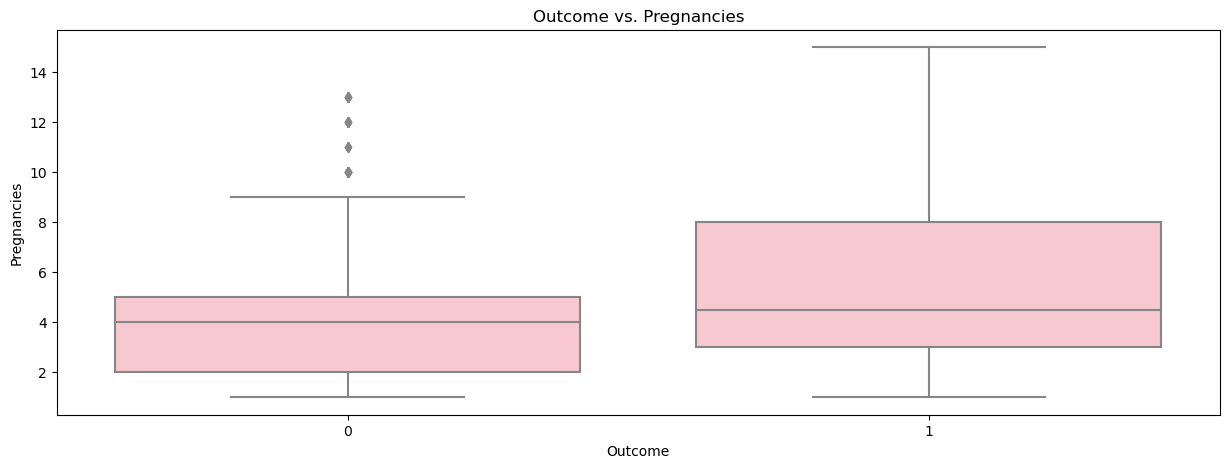

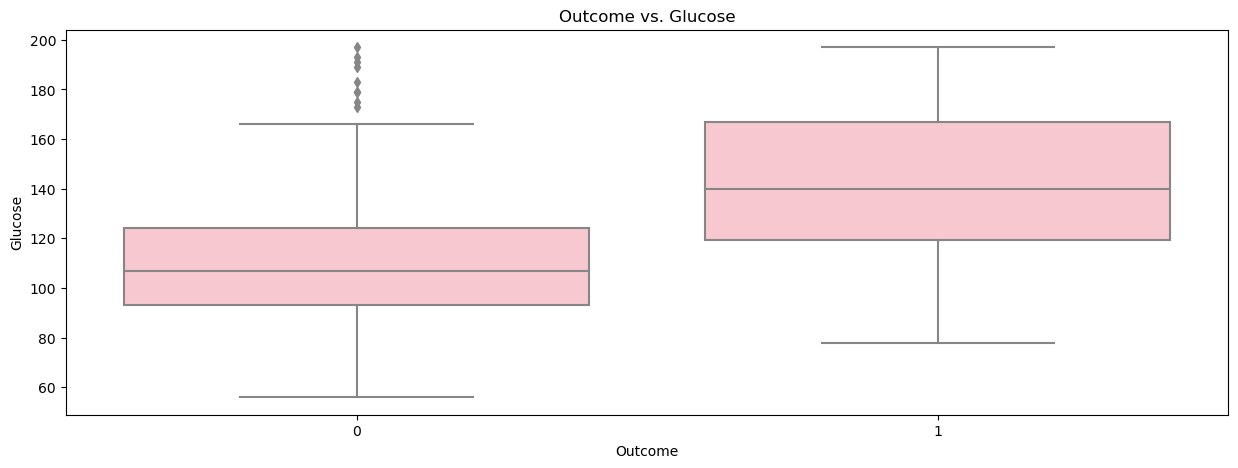

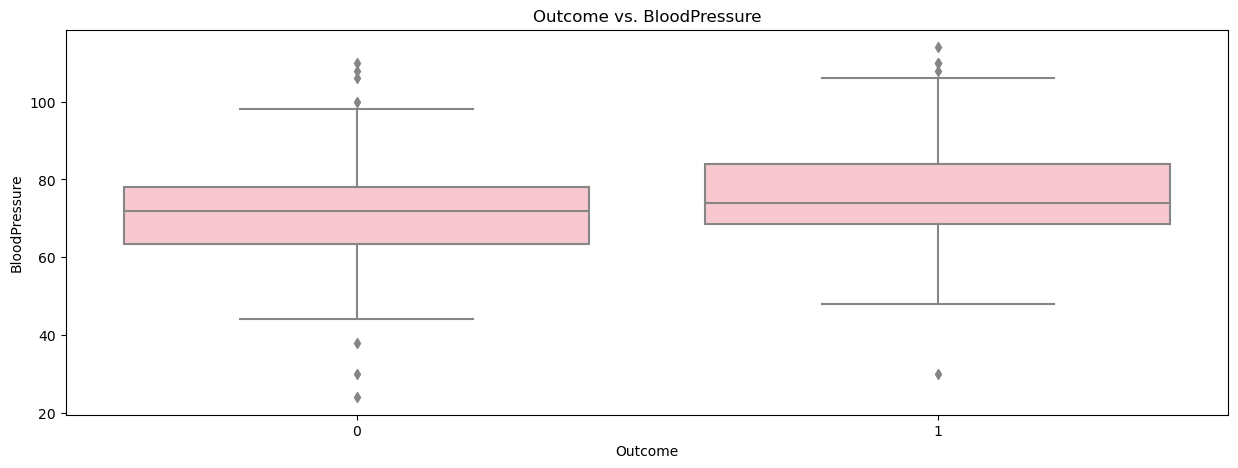

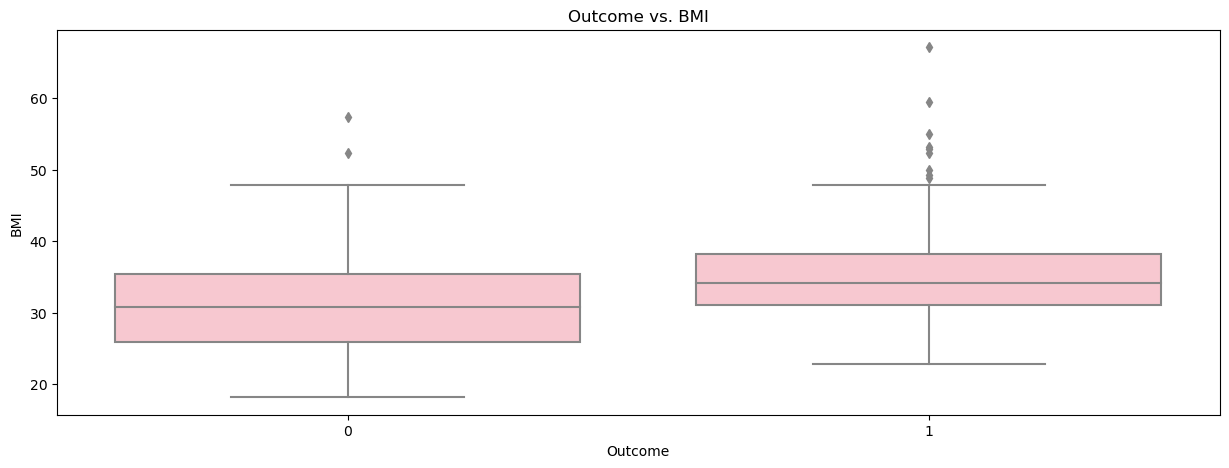

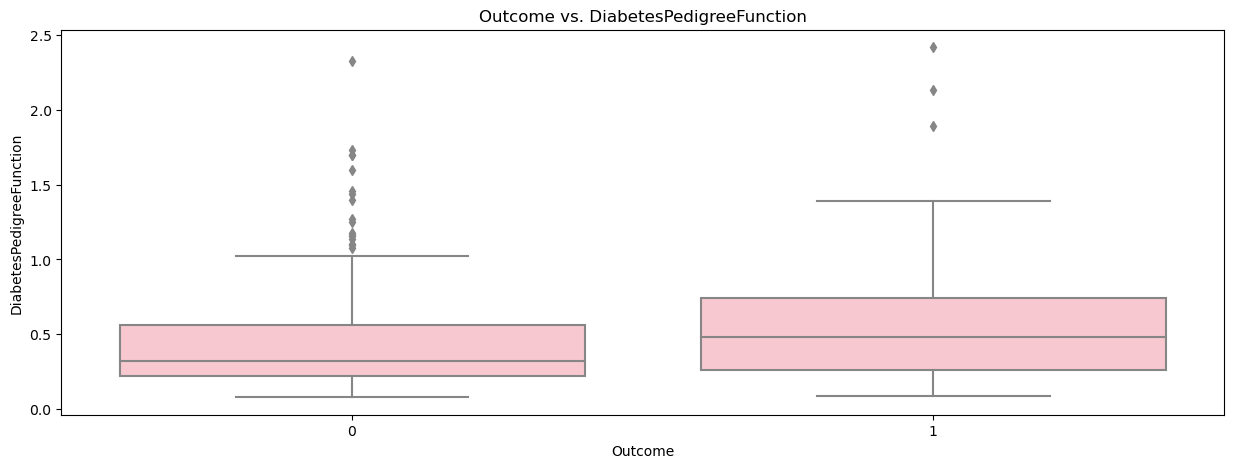

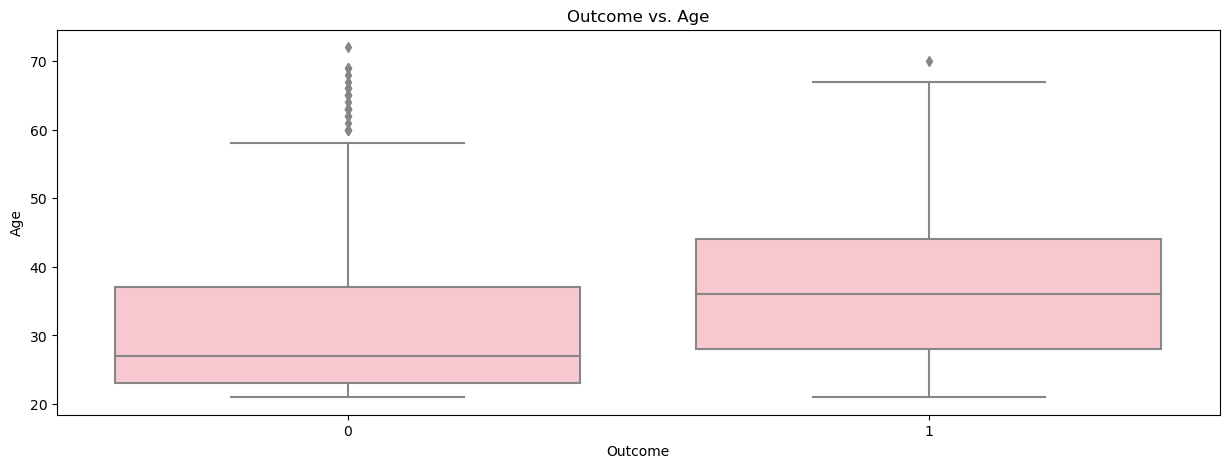

In [335]:
boxplots(df_train, 'Outcome')

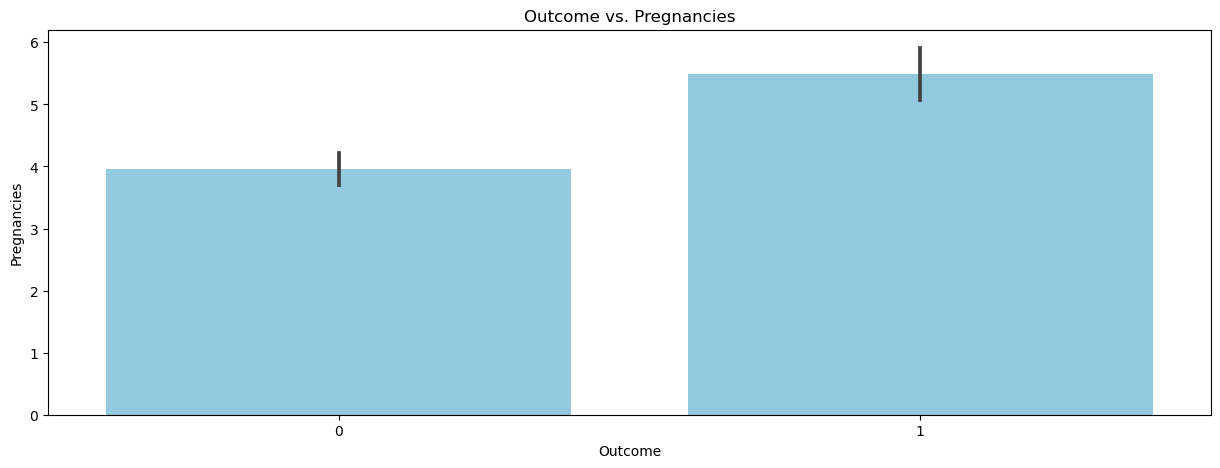

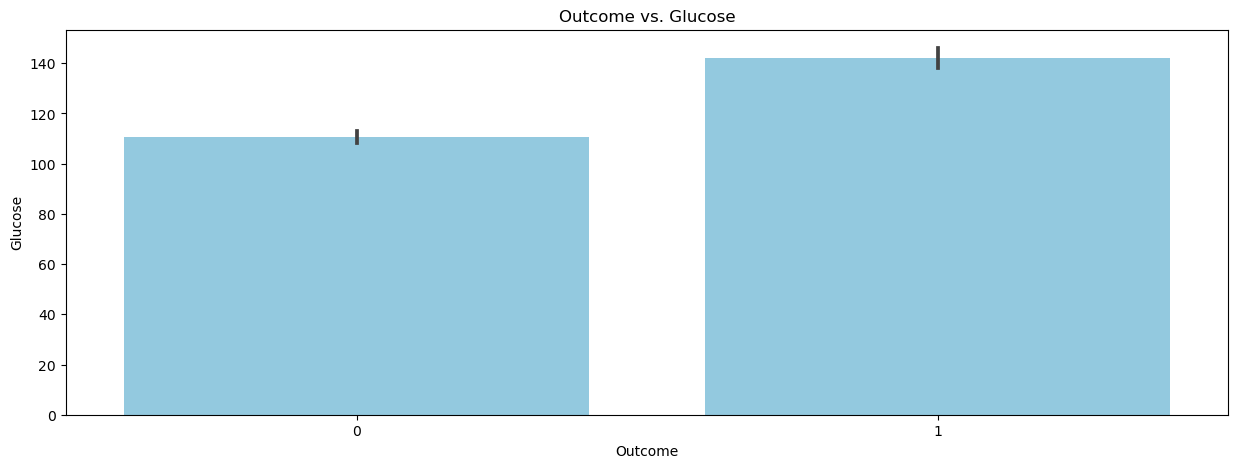

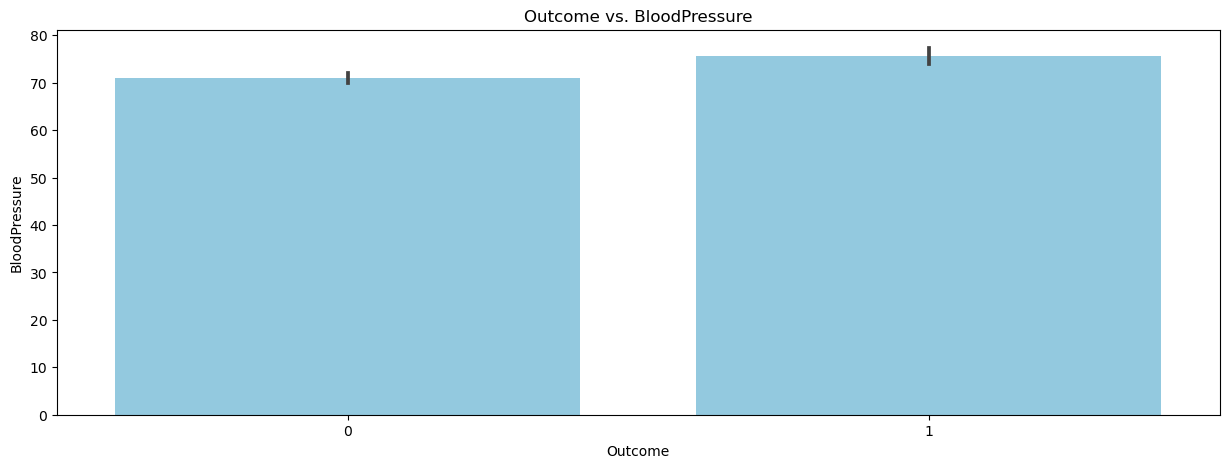

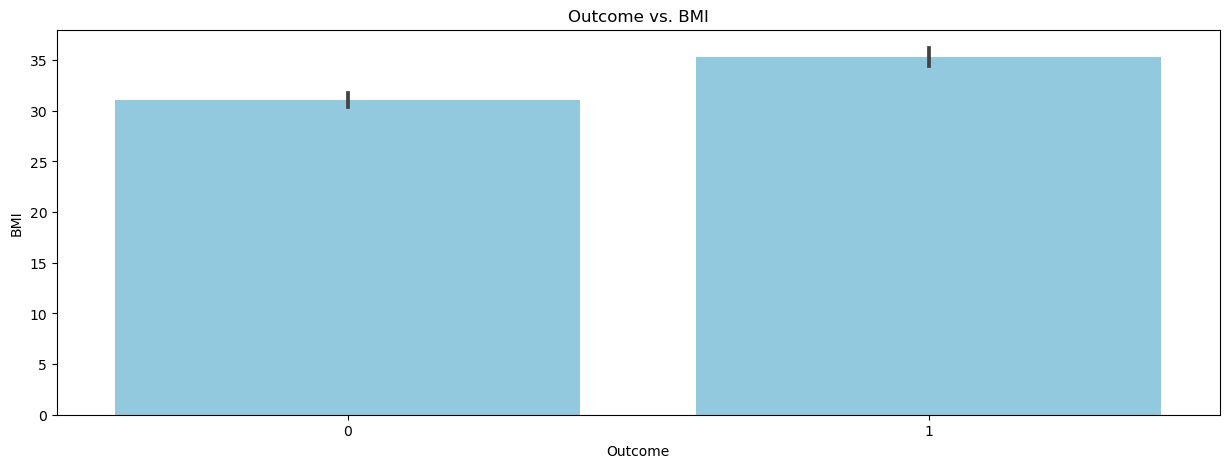

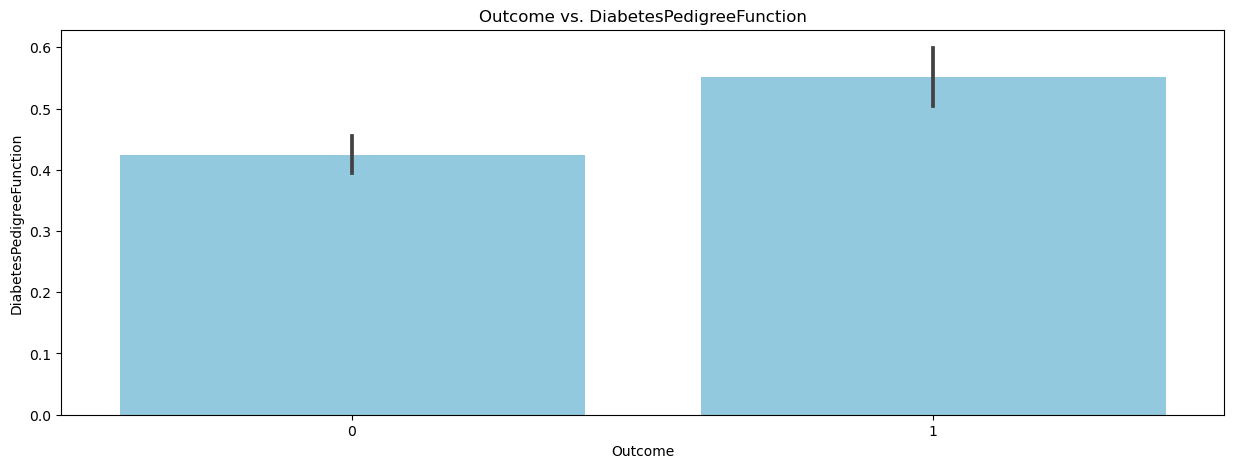

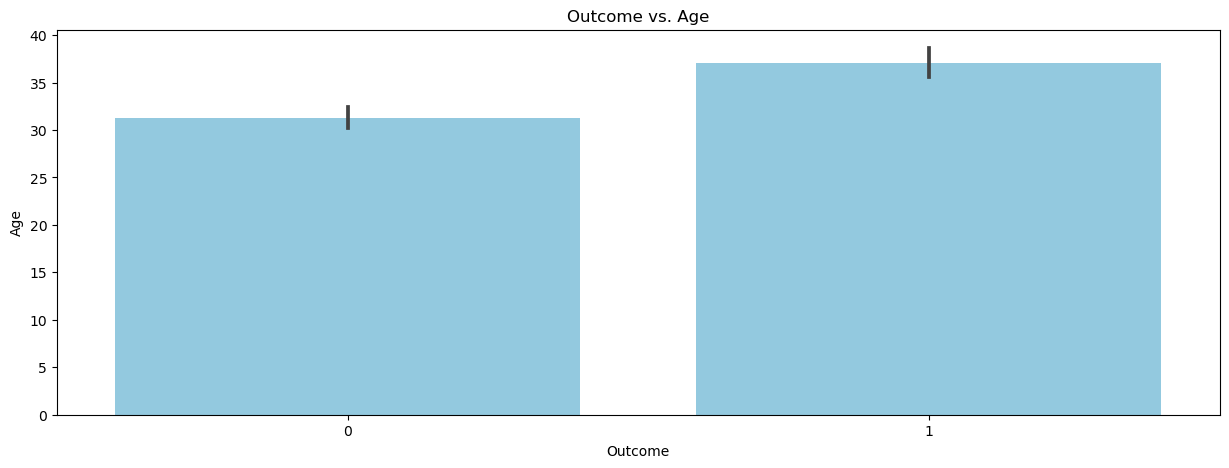

In [336]:
barplots(df_train, 'Outcome')

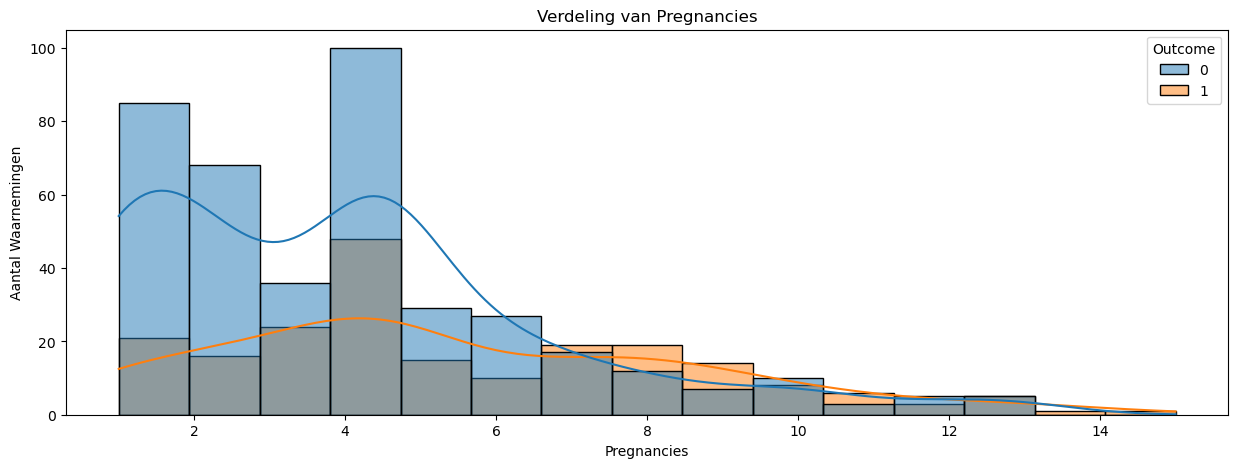

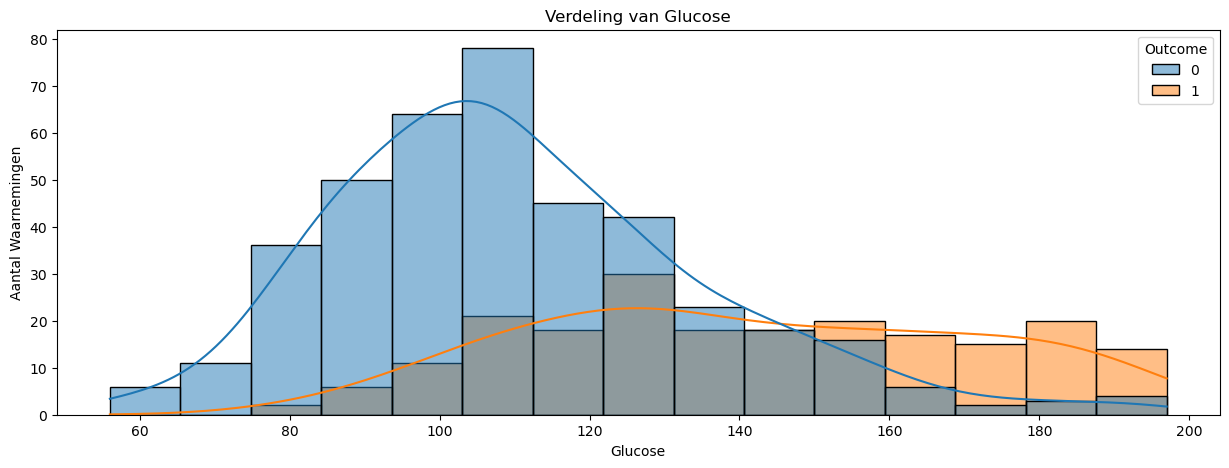

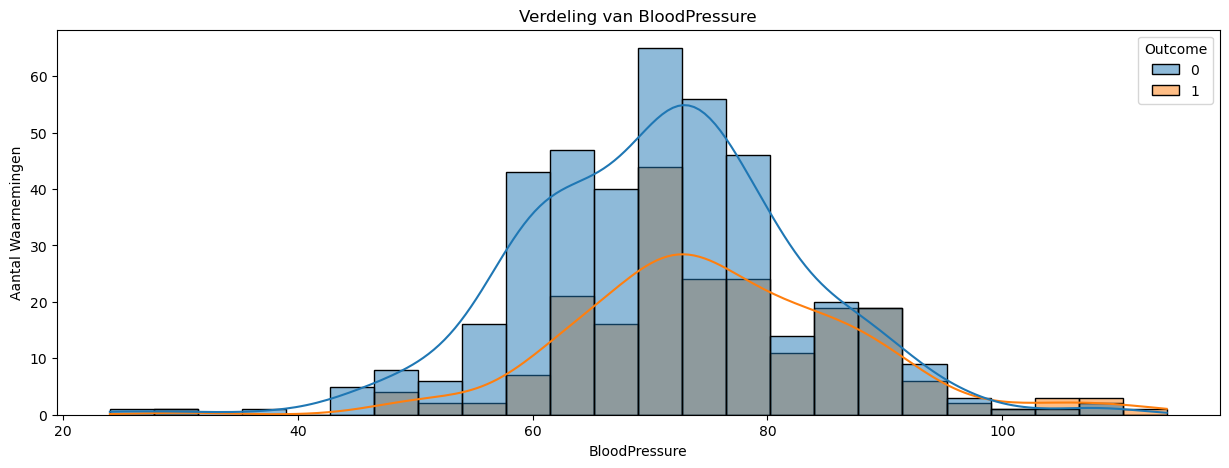

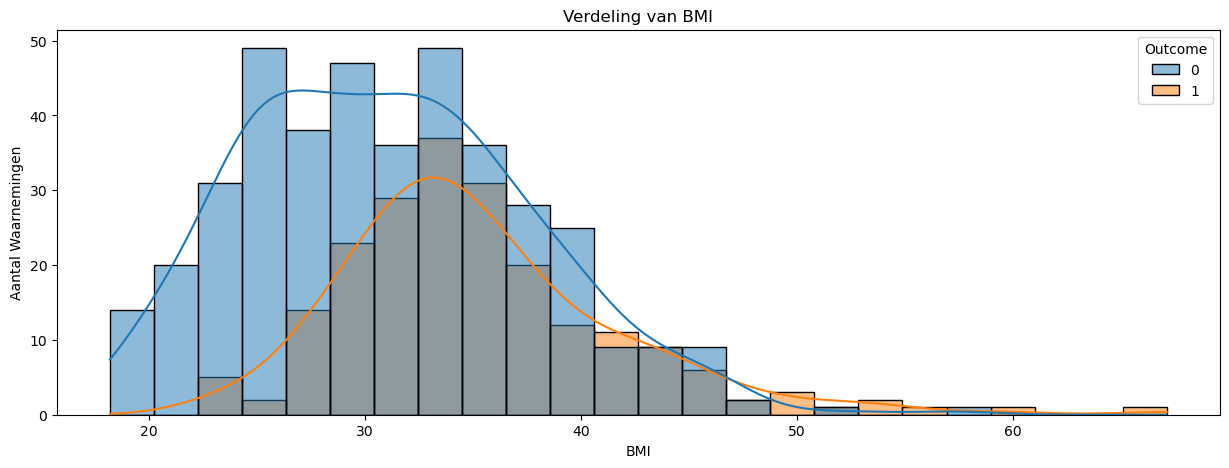

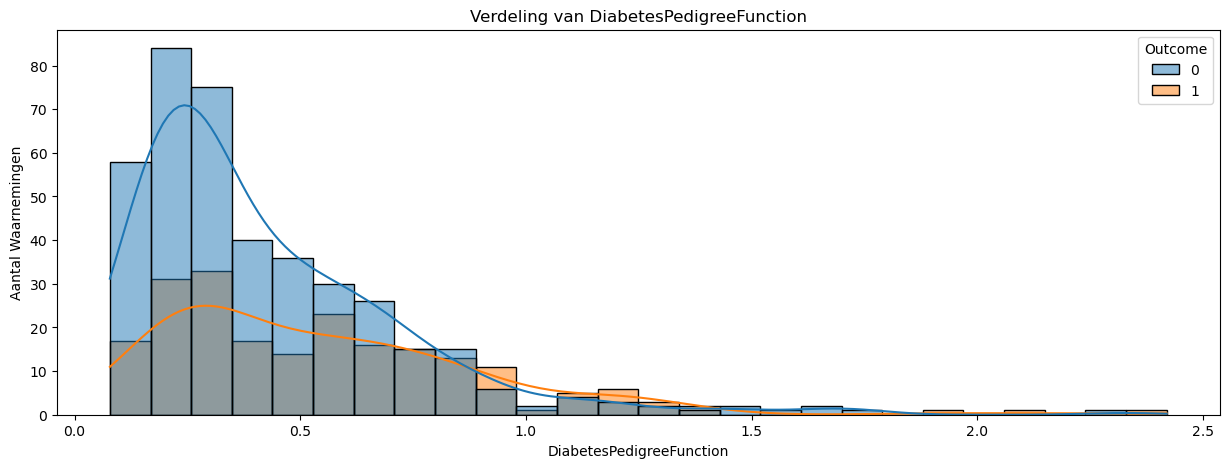

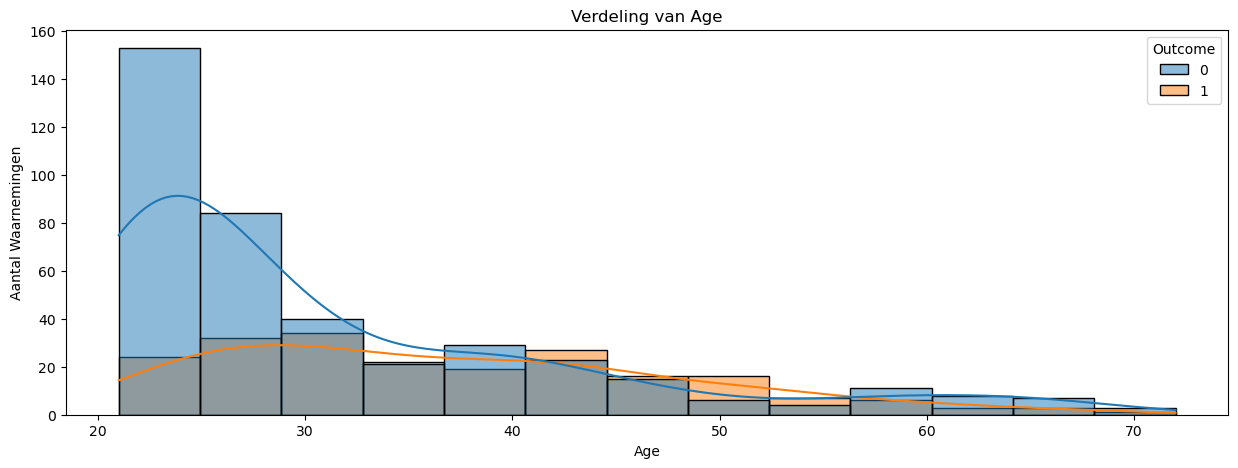

In [337]:
histplots(df_train, 'Outcome')

Bij de visualisaties van de boxplot en barplot kun je zien dat mensen met diabetes (Outcome = 1) vaker zwanger zijn, een hogere glucose waarde hebben, een hogere bloeddruk, een hoger bmi en een hoger diabetes pedigree function hebben, vaak zijn ze ook ouder.

Bij de visualisatie van de histplot zie je hetzelfde maar dan op een andere manier. Je ziet dat op het begin de staven voornamelijk blauw (Outcome = 0) zijn en naarmate de waardes hoger worden er meer oranje (Outcome = 1) is te zien.

De conclussie die wij hier uit trekken is: mensen die diabetes hebben, hebben gemiddeld hogere waardes dan mensen zonder diabetes.

### **H1.2: Standaardisatie**

In een data science project, is de data standaardiseren een cruciaal onderdeel van het pre-processing van de data. In dit proces worden de variabelen omgezet in vergelijkbare schalen, zodat ze op dezelfde manier kunnen worden geïnterpreteerd en vergeleken. Als dit niet gebeurt, dan kan het model niet de juiste conclusies trekken.  

Standaardisatie heeft als hoofddoel om ervoor te zorgen dat de variabelen in een dataset vergelijkbaar zijn en op een consistente manier kunnen worden geïnterpreteerd. Hierdoor zijn analyses, modellering en visualisaties makkelijker, en het helpt bij het elimineren van vertekeningen veroorzaakt door verschillen in schaal of eenheden tussen variabelen. 

Veel machine learning algoritmen zijn gevoelig voor de schaal tussen variabelen in een dataset, door de data te standaardiseren kunnen de prestaties van een machine learning model worden verbeterd.  Als voorbeeld, een dataset die de variabelen “inkomen” en “leeftijd” bevat zal de variabele “inkomen” belangrijker beschouwen dan leeftijd omdat de schaal zoveel hoger is. Bij veel machine learning algoritmen is standaardiseren nodig, maar niet alle. Een decision-tree model is niet gevoelig voor hoge verschillen in de variabelen bijvoorbeeld. 

#### **Data standaardisatie in onze dataset**

In onze dataset zijn de waardes redelijk vergelijkbaar, behalve de variabelen insuline en glucose. Insuline heeft een maximum van 744, en glucose 197. Terwijl de andere variabelen tussen de 10-100 liggen. Toevallig bevat Insuline zoveel missende waardes dat we ervoor hebben gekozen deze te verwijderen. Glucose aan de andere kant moet wel gestandaardiseerd worden wanneer we de machine learning modellen gaan toepassen.

In [338]:
from sklearn.preprocessing import MinMaxScaler

def feature_scaling(data):
    """
    Een functie om de gegeven data te scalen
    via de min-max methode. Hiermee vallen alle
    waarden tussen 0 en 1, zodat alles op
    dezelfde schaal wordt vergeleken.

    Parameters:
    ----------
    data : pd.DataFrame
    Het dataframe die je gaat scalen

    Returns:
    ----------
    scaled_data : pd.DataFrame
    Het dataframe waar alle data is gescaled
    """

    # Selecteren van de numerieke kolommen
    kolommen = data.select_dtypes(include=['number']).columns

    # Opzetten scaler
    scaler = MinMaxScaler()

    # Scalen van de data
    scaled_data = data.copy()
    scaled_data[kolommen] = scaler.fit_transform(data[kolommen])

    return scaled_data

In [339]:
train_scaled = feature_scaling(df_train)
train_scaled.describe()

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,Outcome
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.249246,0.462807,0.539642,0.292681,0.166565,0.240499,0.342020
std,0.211887,0.215829,0.133553,0.141059,0.140565,0.232381,0.474773
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.071429,0.306738,0.444444,0.192229,0.068318,0.058824,0.000000
50%,0.249246,0.425532,0.539642,0.290389,0.122758,0.156863,0.000000
75%,0.357143,0.595745,0.622222,0.374233,0.235056,0.392157,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## ***H2: Machine Learning en Metrics***

### **H2.1: De vorm van Machine Learning**
Bij deze opdracht is er sprake van een classificatie. De target variabele, 'Outcome', heeft twee mogelijke waarden, dit zijn 0 of 1. De waarde 0 geeft aan dat het individu waarvan de data afkomstig is geen diabetes heeft, bij een waarde van 1 zou het individu wel diabetes hebben.

#### **De metrics van classificatie**
Bij een classificatie worden 4 verschillende metrics gebruikt: accuracy, precision, recall en f1-score. De accuracy is redelijk vanzelfsprekend, deze metric houdt het percentage waarden dat correct is voorspeld in. De andere drie metrics worden hieronder uitgelegd, met behulp van een confusion matrix. In deze cel zal ook de data gesplitst worden in train en test data voor bij het modelleren.

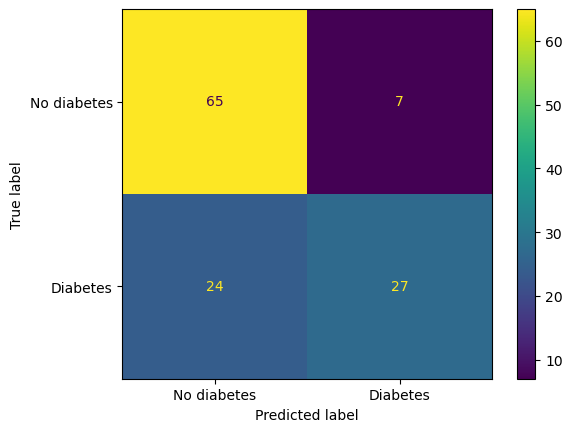

Precision: 0.7941176470588235
Recall: 0.5294117647058824
F1_score: 0.6352941176470589


In [340]:
# Aanmaken SEED voor random_states
SEED = 42

# Scheiden van data in X en y
X = train_scaled.drop('Outcome', axis=1)
y = train_scaled['Outcome']

# Toepassen van train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=SEED,
                                                    test_size=0.2)

# Maken van LR model voor confusion matrix
lr = LogisticRegression(solver='liblinear',
                        random_state=SEED)

# Fitten en voorspellen voor confusion matrix
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Maken van de confusion matrix
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['No diabetes','Diabetes'])
cmd.plot()
plt.show()

# Aangeven van de vakken voor berekening metrics
TP = cm[1,1]
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]

# Berekenen van de metrics
precision = TP / ( TP + FP)
recall = TP / (TP + FN)
f1 = 2 * precision * recall / (precision + recall)
        
print(f"Precision: {precision}\n"\
      f"Recall: {recall}\n"\
      f"F1_score: {f1}")

Zoals er te zien is in de Confusion Matrix, zijn er vier verschillende vlakken. Aan de hand van deze vier vlakken worden de metrics precision, recall en f1 berekend. De vier vlakken kunnen wisselen van locatie aan de hand van de context, ondanks het wisselen van locatie blijven de 4 vlakken wel met dezelfde namen. Deze namen zijn:
- True Positive (Uitkomsten tonen en zijn gewild)
- False Positive (Uitkomsten tonen zich als gewild, maar in de werkelijkheid zijn ze ongewild)
- True Negative (Uitkomsten tonen en zijn ongewild)
- False Negative (Uitkomsten tonen zich als ongewild, maar zijn in werkelijkheid gewild)

De precision metric is de bepaling van het deel positieve voorspellingen dat juist is voorspeld. Een hoge precision toont een laag aantal foutief positieve voorspellingen. De berekening ziet er als volgt uit: $\frac{TP}{(TP + FP)}$

De recall metric is de bepaling van het deel daadwerkelijk positieve uitkomsten dat juist is voorspeld. Een hoge recall toont aan dat het model weinig positieve gevallen over het hoofd ziet. De berekening ziet er als volgt uit: $\frac{TP}{(TP + FN)}$

De F1 score is een bepaling die zowel de precision als de recall in waarde neemt. Hierdoor geeft een hoge f1 score weer dat er op beide metrics goed is gescoord. De f1 score wordt bepaald door de volgende berekening: $ 2 * \frac{(Precision * Recall)}{(Precision + Recall)}$

### **H2.2: Welke metric?**

In ons geval willen we voorspellen of iemand diabetes heeft. Omdat diabetes vrij veel impact op de gezondheid van een persoon heeft, beredeneren wij dat het belangrijker is om zo min mogelijk voorspellingen te hebben die diabetes missen. In context van een confusion matrix, zijn volgens ons de false negatives belangrijker om te voorkomen dan de false positives. Op basis hiervan kiezen wij voor de metric recall. Met recall wordt gekeken hoeveel van de werkelijk positieve voorspelling correct zijn voorspeld. Als de recall hoog is, mist het model nauwelijks positieve gevallen. Het is hierbij belangrijk om te onthouden dat ons model niet te simpel zal zijn. Een model met de functie y=1 zal alles op TP of FP gaan zetten, dit leidt uiteindelijk tot een perfecte recall. Dus hoewel wij een hoge recall willen hebben, is het belangrijk om eventuele recall scores goed te bekijken en benaderen.

Hoewel wij persoonlijk de recall het belangrijkste vinden, zal op Kaggle de F1 scores van de voorspellingen worden gebruikt. Om deze reden zal er getest worden met de F1 score i.p.v. de recall.

## ***H3: Modelleren***

Eerst zal de data uit het test dataframe omgezet aangepast worden om overeen te komen met de data uit de train dataset.

In [341]:
# Copy maken van dataset
df_test = data_test.copy()

# Aanmaken X_kolommen voor replace
df_test[X_kolommen] = df_test[X_kolommen].replace(0, np.nan)

# Berekenen en vullen gem
gem = df_test.mean()
df_test.fillna(gem, inplace=True)

# Weghalen van kolommen wegens te hoog aantal nulwaarden
df_test.drop('Insulin', axis=1, inplace=True)
df_test.drop('SkinThickness', axis=1, inplace=True)

df_test.drop('p_id', axis = 1, inplace=True)

test_scaled = feature_scaling(df_test)
test_scaled.describe()

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age
count,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000
mean,0.219669,0.512292,0.387480,0.445826,0.168873,0.202381
std,0.188787,0.196715,0.151428,0.215945,0.157059,0.190444
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.062500,0.361290,0.292683,0.277778,0.063452,0.050000
50%,0.219669,0.503226,0.388862,0.431746,0.126211,0.133333
75%,0.312500,0.622581,0.487805,0.605556,0.229926,0.316667
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Nu zullen er een paar functies worden aangemaakt, om onder andere op een gemakkelijke manier de voorspellingen van een model om te zetten naar een csv bestand. Ook worden er functies gemaakt voor het berekenen van de score bij zowel de normale modellen als de grid search.

In [342]:
def submissie(model, suffix):
    """
    Deze functie maakt de voorspelling op de test dataset
    en vormt deze om tot een csv bestand om in te kunnen
    leveren op Kaggle.

    Parameters:
    ----------
    model : Machine Learning model
        De naam die is gegeven aan het ML-model dat
        wordt gebruikt om te voorspellen

    suffix : str
        De laatste 'tag' voor de naam van het csv
        bestand, zodat deze makkelijk te identificeren
        is na de submission.

    Returns:
    ----------
    None
        In plaats van een return maakt het een bestand
        aan in de map Kaggle Submissions. De namen zien
        er als volgt uit:

    """
    # Fitten, voorspellen en veranderen naar integer
    y_pred = model.fit(X_train, y_train).predict(test_scaled)
    y_pred = y_pred.astype(int)

    # Aanmaken df met alleen p_id en Outcome
    test_predictions_df = pd.DataFrame(
        {'p_id': data_test['p_id'],
        'Outcome': y_pred})
    
    # Aanmaken van tijd
    tijd = datetime.datetime.now().strftime("%m%d%H%M%S")

    # Aanmaken csv bestand met timestamp
    test_predictions_df.to_csv(
        f'Kaggle Submissions/vs_{suffix}_{tijd}.csv',
        index=False)
    
    # print voor conformatie
    print(f'vs_{suffix}_{tijd}.csv has been saved!')

def model_score(model):
    """
    Een functie die de scores voor een model
    berekend en deze toont.

    Parameters:
    ----------
    model : elk ML model
    De naam van het gemaakte ML model

    Returns:
    ----------
    f1 : int
    De f1 score van het gegeven model
    """

    # Fitten en voorspellen met model
    y_pred = model.fit(X_train, y_train).predict(X_test)

    # Tonen van de resultaten
    return print(f'F1 score: {f1_score(y_test, y_pred)}')

def grid_score(estimator, param_grid):
    """
    Een functie die de scores voor een grid search
    berekend en deze toont. Hierbij worden ook de
    optimale parameters getoont.

    Parameters:
    ----------
    estimator : ML model
    Het model waarop de grid search wordt toegepast

    param_grid : dict
    Een dictionary waarbij de keys parameter namen
    zijn van het model en de values verschillende
    waarden die de parameter aan kan nemen.

    Returns:
    ----------
    None
    Returned twee prints met de optimale parameters
    en beste f1 score
    """

    # Uitvoeren van de grid search
    gs = GridSearchCV(estimator=estimator,
                    param_grid=param_grid,
                    cv=cv,
                    scoring='f1',
                    n_jobs=-1)
    
    # Fitten van de grid search
    gs.fit(X_train, y_train)

    # Tonen van de beste score en parameters
    print(f"Beste f1: {gs.best_score_}")
    print(f"Beste parameters:\n{gs.best_params_}")

Nu zal de standaard CV methode aangemaakt worden, zodat deze code zich niet meerdere keren herhaald bij de GridSearch stappen.

In [343]:
cv = RepeatedStratifiedKFold(n_splits=5, 
                             n_repeats=3, 
                             random_state=SEED)

Nu alle voorbereidende stappen zijn gedaan kunnen de modellen worden gemaakt, verbeterd en gebruikt om zo sterk mogelijke voorspellingen te creeëren.

### **H3.1: Logistische Regressie**

#### **De werking van LR** 
Bij logistice regressie wordt de waarde van een afhankelijke variabele voorspelt op basis van een of meerdere onafhankelijke variabelen. Logistische regressie wordt gebruikt bij classificatie problemen.

#### **Loss functie**

$BCE = -\frac{1}{N} \sum_{i=1}{N} \left[ y_true \log(\hat{y_pred}) + (1-y_true) \log(1-\hat{y_pred}) \right]$

y_true is 1 of 0 (positief of negatief)

y_pred is een kans tussen 0 en 1

#### **Gradient descent**

Gradien descent is een optimalisatie algoritme dat de erors minimaliseert tussen de true en predicticted resultaten. De formule van gradient descent is $x_{new} = x_{old} - a * \frac{d_y}{d_x}$. Waarbij $x_{new}$ de bijgewerkte waarde van de onafhankelijke variabele na één stap is, $x_{old}$ is de vorige waarde van de onafhankelijke variabele, $\frac{d_y}{d_x}$ de gradiënt (afgeleide) van deze functie ten opzichte van de onafhankelijke variabele is en $a$ is de learning rate, deze bepaalt de grootte van de stap die wordt genomen.

Als voorbeeld: $y = x^2 - x - 6$ de gradient van deze functie is $f'(x) = 2x-1$. <br>De wiskundige formule van het berekenen van de gradient is $x^n = n*x^{n-1}$


#### **Regularisatie**
De vorm van regularisatie die van toepassing is op logistic regression is de L1 en L2 regularisatie. Ook wel de Lasso (L1) en ridge (L2) regularisatie genoemd. Door regularisatie toe te passen, wordt een complex model tijdens het trainen vereenvoudigd. L1 voegt de “absolute waarde van de grootte” (“absolute value of magnitude”) van de coëfficiënt als penalty term toe aan de loss-functie. L2 voegt de “kwadratische omvang” (“squared magnitude”) van de coëfficiënt als penalty term toe aan de loss-functie. (Nagpal, 2022)

**Lasso (L1)**<br>
Wiskundige formule voor L1 is:
$\lambda||w||_1$

Waarbij:
- $w$ : L1-norm van de gewichtsvector
- $\lambda$ : de regularisatieparameter

Lasso (ook bekend als L1-regularisatie) voegt een term toe aan de loss functie die in gelijke verhouding staat tot de absolute waarden van de gewichten. Het effect dat Lasso heeft is dat het sommige gewichten reduceert to nul. Hierdoor worden sommige kenmerken volledig genegeeerd, waardoor feature selectie mogelijk wordt gemaakt. Door middel van feature selectie wordt de kans op overfitting verminderd. (Jain, 2023; Team, 2020)

**Ridge (L2)**<br>
De Wiskundige formule voor L2 is:
$\lambda w^2$

Waarbij:
- $w$ : L2-norm van de gewichtsvector
- $\lambda$ : de regularisatieparameter

Ridge (ook bekend als L2-regularisatie) voegt een term toe aan de loss functie die in gelijke verhouding staat tot de kwadraten van de gewichten. Het effect dat Ridge heeft is dat het de waarden van gewichten dicht naar de nul brengt, maar niet nul maakt. De ridge manier gaat de mogelijke overfitting tegen door te zorgen dat de gewichten geen te grootte waarden kunnen aannemen. (Jain, 2023; Team, 2020)

Nu het duidelijk is wat Logistische Regressie inhoud, kan er een model worden opgesteld.

In [344]:
# Aanmaken LR model
lr = LogisticRegression(solver='liblinear',
                        random_state=SEED)

# Voorspellen
model_score(lr)

F1 score: 0.6352941176470589


Nu het eerste model is gemaakt gaan we deze tunen met behulp van GridSearchCV. Hiervoor maken we een dictionary aan met de parameters die we willen testen, vervolgens kan GridSearch gebruikt worden.

In [345]:
# Aanmaken parameter dictionary
param_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [500, 1000, 2000, 5000]
}

# Uitvoeren van Grid Search CV
grid_score(lr, param_lr)

Beste f1: 0.6259493599245204
Beste parameters:
{'C': 10, 'max_iter': 500, 'penalty': 'l1'}


Met deze optimale parameters gaan we de voorspellingen opnieuw maken. Deze kunnen vervolgens in een csv bestand worden omgezet om ingeleverd te worden op Kaggle.

In [346]:
# Aanmaken verbeterd LR model
lr_tuned = LogisticRegression(solver='liblinear',
                              C=10,
                              max_iter=500,
                              penalty='l1',
                              random_state=SEED)

# Voorspellen
model_score(lr_tuned)

# Aanmaken CSV
# submissie(lr_tuned, 'LR')

F1 score: 0.651685393258427


### **H3.2: Decision Tree**
Een decision tree model is een vorm van machine learning waarbij het model "beslissingen" maakt om de data de scheiden. Een decision tree model kan gebruikt worden voor beide classificatie of regessie.

#### **Werking Decision Tree**
Een decision tree model is een vorm van supervised machine learning. In dit geval wordt een decision tree classifier gebruikt omdat dit een classificatie probleem is. Het werkt door de dataset recursief te verdelen in "vertakkingen" op basis van de waarden van de invoerfuncties. Deze splitsingen creëren een structuur die op een boom lijkt, waarbij elke vertakking een beslissing of een test op een kenmerk vertegenwoordigt. En op die gesplitste data wordt weer een beslissing genomen, en zo vertakt het model tot we bij de "bladeren" komen. En net zoals bij een boom, noemen we de eerste splitsing de "wortel", en eindigen we bij het blad. Na het blad stopt het model met splitsen. (presentaties lessen, datacamp)

#### **Criteria**
Bij een decision tree model is er keuze uit drie criteria om te gebruiken in het model Deze criteria zijn: gini en log loss/entropy

**Entropy** <br>
In een decision tree model word entropy gebruikt om de onzekerheid weer te geven. De data wordt gesplitst op een manier die de entropy zo veel mogelijk vermindert. Naarmate de tree word gesplitst neemt de entropy af. (Singh, 2022)

De wiskundige formule voor entropy ziet er zo uit: 

$H(Q_m) = - \sum_k p_{mk} \log(p_{mk})$ 
(1.10. Decision Trees, scikit-learn)

**Gini** <br>
Bij gini wordt de data iets anders gesplitst. Gini splitst de data gebaseerd op hoe gelijk de resulterende klassen zijn. Bijvoorbeeld dat een groep alleen uit dezelfde klasse bestaat. (Singh, 2022)

De wiskundige formule voor gini ziet er zo uit:

$H(Q_m) = \sum_k p_{mk} (1 - p_{mk})$ 
(1.10. Decision Trees, scikit-learn)

Aan het eind van de paragraaf is het decision tree model gevisualiseerd.

In [347]:
# Aanmaken DT model
dt = DecisionTreeClassifier(random_state=SEED)

# Voorspellen
model_score(dt)

F1 score: 0.6451612903225806


Nu het eerste model is gemaakt gaan we deze tunen met behulp van GridSearchCV. Hiervoor maken we een dictionary aan met de parameters die we willen testen, vervolgens kan GridSearch gebruikt worden.

In [348]:
# Aanmaken parameter dictionary
param_dt = {
    "criterion": ["gini", "entropy"],
    "max_depth": [5, 10, 20],
    "min_samples_leaf": [2, 4, 8]
}

# Uitvoeren van Grid Search CV
grid_score(dt, param_dt)

Beste f1: 0.5992862882389927
Beste parameters:
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 8}


Met deze optimale parameters gaan we de voorspellingen opnieuw maken. Deze kunnen vervolgens in een csv bestand worden omgezet om ingeleverd te worden op Kaggle.

In [349]:
# Aanmaken verbeterd DT model
dt_tuned = DecisionTreeClassifier(criterion='entropy',
                                  max_depth=5,
                                  min_samples_leaf=8,
                                  random_state=SEED)

# Voorspellen
model_score(dt_tuned)

# Aanmaken CSV
# submissie(dt_tuned, 'dt')

F1 score: 0.5416666666666666


Hier onder kunnen we het model dat zojuist is aangemaakt visualiseren. (ChatGPT, 2023, prompt 1: increase tree plot size)

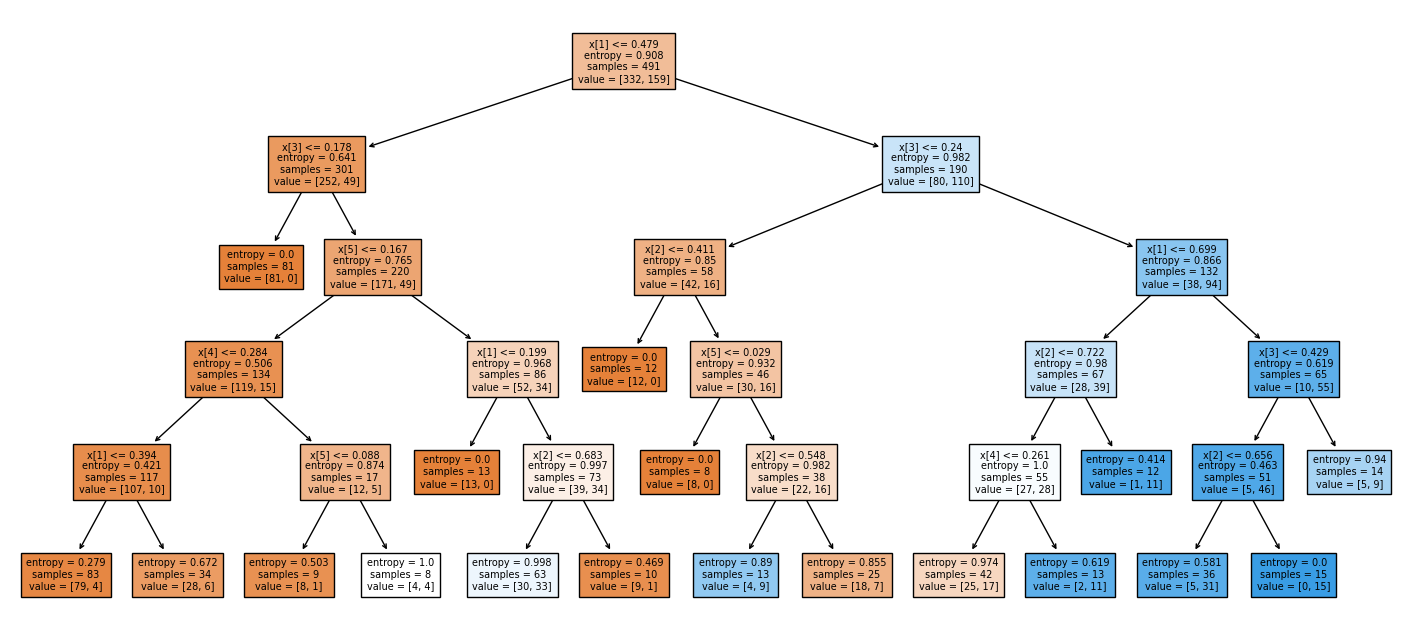

In [350]:
# Het maken van een frame voor de plot
plt.figure(figsize=(18, 8))

# Het plotten van de boom
tree.plot_tree(dt_tuned, filled=True, fontsize=7)
plt.show()

### **H3.3: Random forest**

Random Forest is een vorm van een ensemble model dat gebaseerd is op Decision Tree.

#### **Werking van het Random Forest-model:**
**Bootstrap Aggregating (Bagging):** Random Forest bestaat uit een ensemble van Decision Trees. Elk van deze trees wordt getraind op een steekproef uit de train data, deze is opgesteld door willekeurig rijen te nemen uit de dataset met teruglegging. Dit wordt bootstrapping genoemd.

**Random Feature Selectie:** Bij elke instantie van een Random Forest wordt slechts een deel van de beschikbare functies gekozen om de splitsing te maken. Hierdoor krijgen de individuele trees verschillende perspectieven op de gegevens.

**Voting of Gemiddelde:** In plaats van één enkele Decision Tree om voorspellingen te doen, combineert een Random Forest de voorspellingen van alle bomen in de ensemble door middel van een meerderheidsstemming (voor classificatie) of een gemiddelde (voor regressie).

**Overfitting beperken:** Door de bovenstaande technieken van willekeur en aggregatie te gebruiken, helpt een Random Forest overfitting te verminderen.

#### **Performance in vergelijking met andere tree-based modellen:**
In vergelijking met enkele Decision Trees heeft Random Forest over het algemeen betere prestaties omdat het de neiging tot overfitting vermindert en de nauwkeurigheid van de voorspellingen verhoogt.

Nu duidelijk is hoe Random Forest werkt, zal er een model gemaakt worden.

In [351]:
# Aanmaken RF model
rf = RandomForestClassifier(random_state=SEED,
                            n_jobs=-1)

# Voorspellen
model_score(rf)

F1 score: 0.6736842105263158


Nu het eerste model is gemaakt gaan we deze tunen met behulp van GridSearchCV. Hiervoor maken we een dictionary aan met de parameters die we willen testen, vervolgens kan GridSearch gebruikt worden.

In [352]:
# Aanmaken parameter dictionary
param_rf = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [5, 10, 20]
}

# Uitvoeren van Grid Search CV
grid_score(rf, param_rf)

Beste f1: 0.6218783878850432
Beste parameters:
{'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 200}


#### **Pruning in Random Forest**
Hoewel het niet per se nodig is om pruning toe te passen op Random Forest, is het bij het maken van ons model wel van toepassing gekomen. Door de max_depth aan te passen van None naar 5 is de accuracy van het model verbeterd met ca. 0.04. Dit staat gelijk aan ongeveer 4% accuracy.

Nu de optimale hyperparameters gekozen zijn, worden deze ingevuld bij een Random Forest model om de voorspellingen te verbeteren.

In [353]:
# Aanmaken verbeterd RF model
rf_tuned = RandomForestClassifier(criterion='entropy',
                                  n_estimators=200,
                                  max_depth=10,
                                  random_state=SEED,
                                  n_jobs=-1)

# Voorspellen
model_score(rf_tuned)

# Aanmaken CSV
# submissie(rf_tuned, 'RFC')

F1 score: 0.6808510638297872


### **H3.4: ADA Boosting**

Boosting is het combineren van weak learners samen met strong learners. Een weak learner is een model dat het net iets beter doet dan gokken. Ada Boosting staat voor adaptive boosting. Elke voorspelling geeft meer aandacht aan de gevallen die eerder verkeerd zijn voorspeld. Dit wordt bereikt door de trainingsvoorbeelden een gewicht te geven. De waarde van α hangt af van de trainingsfout van de voorspelling. (Datacamp, n.d.)

In [354]:
# Aanmaken van ADA model
ada = AdaBoostClassifier(random_state=SEED)

# Voorspellen
model_score(ada)

F1 score: 0.693069306930693


Nu het eerste model is gemaakt gaan we deze tunen met behulp van GridSearchCV. Hiervoor maken we een dictionary aan met de parameters die we willen testen, vervolgens kan GridSearch gebruikt worden.

In [355]:
# Aanmaken parameter dictionary
param_ada = {
    'estimator' : [None, dt, dt_tuned],
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.1, 1.0, 10.0]
    }

# Uitvoeren van Grid Search CV
grid_score(ada, param_ada)

Beste f1: 0.6381336509410875
Beste parameters:
{'estimator': None, 'learning_rate': 0.1, 'n_estimators': 100}


Met deze optimale parameters gaan we de voorspellingen opnieuw maken. Deze kunnen vervolgens in een csv bestand worden omgezet om ingeleverd te worden op Kaggle.

In [356]:
# Aanmaken verbeterd ADA model
ada_tuned = AdaBoostClassifier(estimator=None,
                               n_estimators=100,
                               learning_rate=0.1,
                               random_state=SEED)

# Voorspellen
model_score(ada_tuned)

# Aanmaken CSV
# submissie(ada_tuned, 'ADA')

F1 score: 0.6875


### **H3.5: Gradient Boosting**

Gradient boosting is een manier van machine learning gebruikt in regressie and classificatieproblemen waarbij meerdere zogenaamde "weak learners", modellen die weinig aannames doen over de data, als een "ensemble" of samenwerking voorspellingen doen over de data. Er zijn meerdere redenen waarom er voor gradient boosting gekozen wordt in plaats van andere modellen. Omdat er bij gradient boosting gebruik wordt gemaakt van meerdere modellen die de fouten van vorige modellen corrigeren, kan het accurater zijn. Door het gebruik van weak learners is gradient boosting ook bestendiger tegen overfitting.

Er zijn ook een paar nadelen verbonden aan het gebruik van gradient boosting. Het is een stuk complexer dan een standaard model, en deze complexiteit en het gebruik van meerdere bomen zorgt er voor dat de tijd die het kost om het model te maken een stuk langer kan zijn dan een standaard model.

#### **Performance ten opzichte van andere tree-based modellen**

Decision tree modellen hebben de neiging tot overfitten. Gradient boosting probeert dit probleem te corrigeren door het model beter te laten generaliseren. Hierdoor is gradient boosting erg geschikt om te gebruiken in classificatie en regressieproblemen en kan het beter presteren dan een standaard decision tree model. (1.11. Ensembles: Gradient Boosting, Random Forests, Bagging, Voting, Stacking, n.d.)


In [357]:
# aanmaken gradient boosting model
gb = GradientBoostingClassifier(random_state=SEED)

# Voorspellen
model_score(gb)

F1 score: 0.6595744680851063


Nu het eerste model is gemaakt gaan we deze tunen met behulp van GridSearchCV. Hiervoor maken we een dictionary aan met de parameters die we willen testen, vervolgens kan GridSearch gebruikt worden.

In [358]:
# gebruik van gridsearch om de beste parameters te zoeken
param_gb = {
    "criterion" : ["friedman_mse", "squared_error"],
    "learning_rate":[0.1, 5000, 7500, 8000, 8500],
    "n_estimators":[1, 3, 5],
    "max_depth":[2, 3 ,5],
    "min_samples_leaf":[2, 4, 8]
    }

# Uitvoeren van Grid Search CV
grid_score(gb, param_gb)

Beste f1: 0.6399844650390869
Beste parameters:
{'criterion': 'friedman_mse', 'learning_rate': 5000, 'max_depth': 5, 'min_samples_leaf': 8, 'n_estimators': 1}


#### **Pruning**

Zoals bij de standaard decision tree, wordt er hier gebruikt gemaakt van pruning. Door de maximale diepte (max_depth) te limiteren tot 5, wordt voorkomen dat het model te complex is en daardoor zou overfitten. Nadat deze vorm van pruning is toegepast kon het model beter generaliseren en een hogere score halen op nieuwe data.

Met deze optimale parameters gaan we de voorspellingen opnieuw maken. Deze kunnen vervolgens in een csv bestand worden omgezet om ingeleverd te worden op Kaggle.

In [359]:
# model met beste parameters voor Kaggle submissie
gb_tuned = GradientBoostingClassifier(criterion="friedman_mse",
                                      learning_rate=5000,
                                      max_depth=5,
                                      min_samples_leaf=8,
                                      n_estimators=1,
                                      random_state=SEED)

# Voorspellen
model_score(gb_tuned)

# Aanmaken CSV
# submissie(gb_tuned, 'GB')

F1 score: 0.6518518518518519


### **H3.6: Support Vector Machines**

#### **Werking van SVM**
Een Support Vector Machine is een model dat ingezet kan worden bij classificatie en regressie problemen. Bij classificatie heeft het model als doel om een hyperplane (de beslissingsgrens) te vinden, waarbij de datapunten in verschillende klassen worden gescheden en waarbij een zo groot mogelijke marge tussen de klassen zit. In een deel van de ML-problemen zal de hyperplane van een SVM model een lineaire vergelijking aannemen. Aan de hand van een wiskundig voorbeeld zal dit worden uitgelegd:

Elk gegeven punt in de grafiek voor SVM zal bestaan uit een waarde (x, y). Het doel van SVM is om een grens te maken tussen de punten, om zo deze punten te classificeren. In onze dataset ziet de formule voor deze lijn er als volgt uit:

$w_1x_1 + w_2x_2 + w_3x_3 + w_4x_4 + w_5x_5 + w_6x_6 + b = 0$. 

Bij deze formule zijn $w$ de gewichten die de helling bepalen, $b$ is de bias term die de verschuiving bepaald en $x$ staat voor de betreffende kolom. De verschillende getallen achter de $w$ en de $x$ staan voor de verschillende parameters van het model. Het doel is dan om, aan de hand van de bovenstaande formule, een lijn te trekken waardoor de voorspellingen zo accuraat mogelijk worden voorspeld. Dit terwijl de marge tussen de punten en de lijn zo groot mogelijk blijft. De uitkomsten van de formule tonen aan waar het punt zou moeten liggen, aan de positieve of de negatieve kant van de lijn. Om de marge vervolgens te optimaliseren gebruiken we de volgende formule: $\frac{2}{||w||}$. Hierbij is $||w||$ de norm van de vector, dit is veel gebruikt om de lengte van een vector te meten.

In sommige gevallen zijn de gegevens niet goed lineair scheidbaar, in dit geval wordt de kerneltruc toegepast. Een kernel is een functie die de gegevens naar een hogere dimensionale ruimte projecteert, waar ze mogelijk lineair scheidbaar zijn. De kerneltruc maakt het mogelijk om deze projectie te vermijden en berekeningen direct in de oorspronkelijke ruimte uit te voeren, waardoor SVM geschikt is voor complexe datasets. Kortom: de kerneltruc helpt SVM bij het modelleren van niet-lineaire beslissingsgrenzen. (Pupale, 2022; Team, 2020; Tieleman, 2023)

#### **Loss functie**
De loss functie bij SVM ziet er als volgt uit (Roun, 2013):

$Loss = \sum_{i=1}^{N} max(0,1 - y_i(w^Tx_i + b)) + \lambda w^2$

Uitleg van letters bij Loss functie:
- $N$: Het aantal datapunten
- $x_i$: een datapunt
- $y_i$: de label van datapunt $x_i$
- $w$: de gewichtsvector van de hyperplane
- $b$: de bias-term
- $\lambda$: de regularisatieparameter
- $w^2$: de L2-norm van de gewichtsvector

Het eerste deel van de functie ($\sum_{i=1}^{N} max(0,1 - y_i(w^Tx_i + b))$) meet hoe ver alle punten aan de verkeerde kant van de lijn staan. Als het label correct is voorspeld is de loss gelijk aan 0, zo niet dan neemt de loss meer toe naarmate de fout groter is. Het tweede deel van de functie ($\lambda w^2$) is de toegepaste vorm van regularisatie, in de bovenstaande functie is er gebruikt gemaakt van Ridge regularisatie. In de onderstaande tekst worden Ridge en Lasso, de vormen van regularisatie, besproken en uitgelegd.

#### **Regularisatie bij SVM**
De vorm van regularisatie die van toepassing is op Support Vector Machines is de L1 en L2 regularisatie. Ook wel de Lasso (L1) en ridge (L2) regularisatie genoemd. Door regularisatie toe te passen, wordt een complex model tijdens het trainen vereenvoudigd. L1 voegt de “absolute waarde van de grootte” (“absolute value of magnitude”) van de coëfficiënt als penalty term toe aan de loss-functie. L2 voegt de “kwadratische omvang” (“squared magnitude”) van de coëfficiënt als penalty term toe aan de loss-functie. (Nagpal, 2022)

**Lasso (L1)**<br>
Wiskundige formule voor L1 is:
$\lambda||w||_1$

Waarbij:
- $w$ : L1-norm van de gewichtsvector
- $\lambda$ : de regularisatieparameter

Lasso (ook bekend als L1-regularisatie) voegt een term toe aan de loss functie die in gelijke verhouding staat tot de absolute waarden van de gewichten. Het effect dat Lasso heeft is dat het sommige gewichten reduceert to nul. Hierdoor worden sommige kenmerken volledig genegeeerd, waardoor feature selectie mogelijk wordt gemaakt. Door middel van feature selectie wordt de kans op overfitting verminderd. (Jain, 2023; Team, 2020)

**Ridge (L2)**<br>
De Wiskundige formule voor L2 is:
$\lambda w^2$

Waarbij:
- $w$ : L2-norm van de gewichtsvector
- $\lambda$ : de regularisatieparameter

Ridge (ook bekend als L2-regularisatie) voegt een term toe aan de loss functie die in gelijke verhouding staat tot de kwadraten van de gewichten. Het effect dat Ridge heeft is dat het de waarden van gewichten dicht naar de nul brengt, maar niet nul maakt. De ridge manier gaat de mogelijke overfitting tegen door te zorgen dat de gewichten geen te grootte waarden kunnen aannemen. (Jain, 2023; Team, 2020)

Nu er kennis is gemaakt met het model kan er worden gecodeerd in python:

In [360]:
# Aanmaken SVM model
svmc = SVC(random_state=SEED)

# Voorspellen
model_score(svmc)

F1 score: 0.6444444444444445


Nu het eerste model is gemaakt gaan we deze tunen met behulp van GridSearchCV. Hiervoor maken we een dictionary aan met de parameters die we willen testen, vervolgens kan GridSearch gebruikt worden.

In [361]:
# Aanmaken parameter dictionary
param_svm = {
    'C': [0.001, 0.01, 0.1, 1.0, 10.0],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.001, 0.01, 0.1, 1.0, 10.0],
    'degree': [1, 2, 3]
}

# Uitvoeren van Grid Search CV
grid_score(svmc, param_svm)

Beste f1: 0.6208051741557202
Beste parameters:
{'C': 10.0, 'degree': 1, 'gamma': 0.001, 'kernel': 'linear'}


Met deze optimale parameters gaan we de voorspellingen opnieuw maken. Deze kunnen vervolgens in een csv bestand worden omgezet om ingeleverd te worden op Kaggle.

In [362]:
# Aanmaken verbeterd SVM model
svmc_tuned = SVC(kernel='linear',
                 C=10.0,
                 degree=1,
                 gamma=0.001,
                 random_state=SEED)

# Voorspellen
model_score(svmc_tuned)

# Aanmaken CSV
# submissie(svmc_tuned, 'SVM')

F1 score: 0.6206896551724139


### **H3.7: Keuze model: Naive Bayes**

Het Naive Bayes model werkt het beste op goed verdeelde datasets die niet al te groot zijn. Door de feature_scaling die is toegepast is de data op een normale manier verdeeld en zal dit model hopelijk goede voorspellingen kunnen maken. Om kort iets dieper in te gaan op het model zelf, is er een korte uitleg toegevoegd:

Het Naive Bayes model is berust op het Bayes Theorum. Deze theorie heeft de volgende formule:
```
P(A|B) = (P(B|A) * P(A)) / P(B)
```
Deze waarden betekenen het volgende:
```
P(A|B) is de kans dat event A voorkomt als B waar is
P(B|A) is de kans dat event B voorkomt als A waar is
P(A) is de kans op het waarnemen van event A
P(B) is de kans op het waarnemen van event B
```
Naive Bayes berekent voor de rijen de kans op P(A|B), die geeft uiteindelijk de keuze door van het model. (Wikipedia Contributors, 2023)

In [363]:
# Aanmaken van NB model
nb = GaussianNB()

# Voorspellen
model_score(nb)

F1 score: 0.6947368421052633


Nu het eerste model is gemaakt gaan we deze tunen met behulp van GridSearchCV. Hiervoor maken we een dictionary aan met de parameters die we willen testen, vervolgens kan GridSearch gebruikt worden.

In [364]:
# Aanmaken parameter dictionary
param_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
    }

# Uitvoeren van Grid Search CV
grid_score(nb, param_nb)

Beste f1: 0.6108923501469483
Beste parameters:
{'var_smoothing': 0.02310129700083159}


Met deze optimale parameters gaan we de voorspellingen opnieuw maken. Deze kunnen vervolgens in een csv bestand worden omgezet om ingeleverd te worden op Kaggle.

In [365]:
# Aanmaken verbeterd NB model
nb_tuned = GaussianNB(var_smoothing=0.02310129700083159)

# Voorspellen
model_score(nb_tuned)

# Aanmaken CSV
# submissie(nb_tuned, 'NB')

F1 score: 0.6947368421052633


### **H3.8: Ensemble model**

Een ensemble model bestaat uit een combinatie van verschillende Machine Learning modellen. Deze worden gecombineerd om een betere voorspelling op te stellen dan een enkel model zou kunnen doen. Het idee achter het combineren van modellen is dat elk model zwakke en sterke punten heeft, maar door het combineren kunnen deze zwakke punten gecompenseerd worden door de sterke punten van de andere modellen. Vaak geeft een ensemble model een robuustere en nauwkeurigere voorspelling. 

Natuurlijk kan het voorkomen dat verschillende modellen andere voorspellingen geven, maar hoe wordt er dan gekozen voor een uitkomst? Om deze vraag te beantwoorden is er een "voting" opgesteld tussen de modellen. Bij ensemble zijn er 2 typen van voting: hard voting en soft voting.

- **Hard voting** laat de modellen in de ensemble elk een voorspelling doen en door middel van een meerderheidsstemming zal de uiteindelijke voorspelling worden bepaald. Kortom: de meest voorkomende voorspelling wordt gekozen. Om deze reden wordt er ook gebruik gemaakt van een oneven aantal modellen, om toeval te voorkomen. Hard voting wordt veel gebruikt voor classificatie problemen waarbij er duidelijke klassen zijn.
- **Soft voting** laat de modellen in de ensemble elk een waarschijnlijkheid geven voor de voorspelling. De uiteindelijke voorspelling wordt vervolgens berekend door het gemiddelde te nemen van alle waarschijnlijkheden en de hoogste waarschijnlijkheidswaarde te kiezen. Soft voting wordt gebruikt bij zowel classificatie als regressieproblemen.

Wij hebben, bij onze ensemble, gekozen om hard voting toe te passen. Dit lijkt ons de beste keuze omdat er een duidelijk verschil zit tussen de voorspelbare waarden, namelijk 0 voor geen diabetes en 1 voor wel diabetes. De eerste ensemble zal worden gedaan met Logistic Regression, Naive Bayes en Random Forest. Daarna wordt aan de hand van een gridsearch de beste combinatie van modellen bepaald. (Awan-Ur-Rahman, 2023)

In [366]:
# Maken van lijst modellen
modellen = [('lr', lr), ('nb', nb), ('rf', rf)]

# Aanmaken van test VC model
vc_test = VotingClassifier(estimators=modellen,
                      voting='hard',
                      n_jobs=-1)

# Voorspellen
model_score(vc_test)

F1 score: 0.6813186813186813


Nu het vc model is aangemaakt zal er een gridsearch plaatsvinden om de beste combinatie van modellen te vinden.

In [367]:
# Aanmaken parameter dictionary
param_combinations = {
    'estimators' : [
        [('lr', lr), ('dt', dt), ('rf', rf)],
        [('lr', lr), ('dt', dt), ('ab', ada)],
        [('lr', lr), ('dt', dt), ('gb', gb)],
        [('lr', lr), ('dt', dt), ('svm', svmc)],
        [('lr', lr), ('dt', dt), ('nb', nb)],
        [('lr', lr), ('rf', rf), ('ab', ada)],
        [('lr', lr), ('rf', rf), ('gb', gb)],
        [('lr', lr), ('rf', rf), ('svm', svmc)],
        [('lr', lr), ('rf', rf), ('nb', nb)],
        [('lr', lr), ('ab', ada), ('gb', gb)],
        [('lr', lr), ('ab', ada), ('svm', svmc)],
        [('lr', lr), ('ab', ada), ('nb', nb)],
        [('lr', lr), ('gb', gb), ('svm', svmc)],
        [('lr', lr), ('gb', gb), ('nb', nb)],
        [('lr', lr), ('svm', svmc), ('nb', nb)],
        [('dt', dt), ('rf', rf), ('ab', ada)],
        [('dt', dt), ('rf', rf), ('gb', gb)],
        [('dt', dt), ('rf', rf), ('svm', svmc)],
        [('dt', dt), ('rf', rf), ('nb', nb)],
        [('dt', dt), ('ab', ada), ('gb', gb)],
        [('dt', dt), ('ab', ada), ('svm', svmc)],
        [('dt', dt), ('ab', ada), ('nb', nb)],
        [('dt', dt), ('gb', gb), ('svm', svmc)],
        [('dt', dt), ('gb', gb), ('nb', nb)],
        [('dt', dt), ('svm', svmc), ('nb', nb)],
        [('rf', rf), ('ab', ada), ('gb', gb)],
        [('rf', rf), ('ab', ada), ('svm', svmc)],
        [('rf', rf), ('ab', ada), ('nb', nb)],
        [('rf', rf), ('gb', gb), ('svm', svmc)],
        [('rf', rf), ('gb', gb), ('nb', nb)],
        [('rf', rf), ('svm', svmc), ('nb', nb)],
        [('ab', ada), ('gb', gb), ('svm', svmc)],
        [('ab', ada), ('gb', gb), ('nb', nb)],
        [('ab', ada), ('svm', svmc), ('nb', nb)],
        [('gb', gb), ('svm', svmc), ('nb', nb)]
    ]
}

# Uitvoeren van Grid Search CV
grid_score(vc_test, param_combinations)

Beste f1: 0.6253994608897718
Beste parameters:
{'estimators': [('dt', DecisionTreeClassifier(random_state=42)), ('ab', AdaBoostClassifier(random_state=42)), ('nb', GaussianNB())]}


Nu maken we een vc model aan met de uitkomst van de gridsearch, dus met de modellen van Decision Tree, Ada Boosting en Naive Bayes.

In [368]:
# Maken van lijst modellen
modellen = [('dt', dt), ('ab', ada), ('nb', nb)]

# Aanmaken van VC model
vc = VotingClassifier(estimators=modellen,
                      voting='hard',
                      n_jobs=-1)

# Voorspellen
model_score(vc)

F1 score: 0.7083333333333334


Nu dit is gemaakt wordt er met deze modellen een gridsearch uitgevoerd om de meest optimale ensemble te creeëren met deze modellen. De functie is een comment gemaakt om laadtijden te reduceren. De uitkomsten zijn daaronder te vinden.

In [369]:
# Aanmaken parameter dictionary
param_en = {
    'dt__criterion' : ['gini', 'entropy'],
    'dt__max_depth' : [5, 10, 20],
    'dt__min_samples_leaf' : [2, 4, 8],
    'ab__estimator' : [None, dt, dt_tuned],
    'ab__n_estimators': [50, 100, 150, 200],
    'ab__learning_rate': [0.1, 1.0, 10.0],
    'nb__var_smoothing': np.logspace(0,-9, num=5)
}

# Uitvoeren van Grid Search CV
# grid_score(vc, param_en)

```
Beste f1: 0.6412885866182373
Beste parameters:
{'ab__estimator': None, 'ab__learning_rate': 0.1, 'ab__n_estimators': 150, 'dt__criterion': 'entropy', 'dt__max_depth': 20, 'dt__min_samples_leaf': 2, 'nb__var_smoothing': 0.005623413251903491}
```

Met deze optimale parameters gaan we de voorspellingen opnieuw maken. Deze kunnen vervolgens in een csv bestand worden omgezet om ingeleverd te worden op Kaggle.

In [370]:
# Maken van lijst modellen
modellen = [
    ('dt', DecisionTreeClassifier(criterion='entropy',
                                  max_depth=20,
                                  min_samples_leaf=2,
                                  random_state=SEED)),
    ('ab', AdaBoostClassifier(estimator=None,
                              n_estimators=150,
                              learning_rate=0.1,
                              random_state=SEED)),
    ('nb', GaussianNB(var_smoothing=0.005623413251903491))
]

# Aanmaken verbeterd VC model
vc_tuned = VotingClassifier(estimators=modellen,
                            voting='hard',
                            n_jobs=-1)

# Voorspellen
model_score(vc_tuned)

# Aanmaken CSV
# submissie(vc_tuned, 'Ensemble')

F1 score: 0.6451612903225806


## ***H4: Bevindingen***

Nu het modelleren is gedaan, kijken we kort naar alle uitkomsten van de modellen. Zo valt er in één oogopslag te zien welk model het beste heeft gepresteerd.

|Modellen|F1-score
|---|---
|Logistic Regression:              |0.6352941176470589
|Logistic Regression Tuned:        |0.651685393258427
|Decision Tree:                    |0.6451612903225806
|Decision Tree Tuned:              |0.5416666666666666
|Random Forest:                    |0.6736842105263158
|Random Forest Tuned:              |0.6808510638297872
|ADA-Boosting:                     |0.693069306930693
|ADA-Boosting Tuned:               |0.6875
|Gradient Boosting:                |0.6595744680851063
|Gradient Boosting Tuned:          |0.6518518518518519
|Support Vector Machines:          |0.6444444444444445
|Support Vector Machines Tuned:    |0.6206896551724139
|Naive Bayes:                      |0.6947368421052633
|Naive Bayes Tuned:                |0.6947368421052633
|Ensemble Test:                    |0.6813186813186813
|Ensemble Best Combination:        |0.7083333333333334
|Ensemble Tuned:                   |0.6451612903225806

Zoals er te zien is in de bovenstaande tabel, is het Ensemble Best Combination het hoogst scorende model. De F1 score betreft 0.71, wat ook de enige score is die boven de 0.7 uitkomt. De parameters van deze Ensemble waren als volgt:
```
modellen = [('dt', dt), ('ab', ada), ('nb', nb)]

vc = VotingClassifier(estimators=modellen,
                      voting='hard',
                      n_jobs=-1)
```

Echter is er een duidelijk verschil in de performance binnen het notebook en wat er staat bij de scores van Kaggle. Hier is het hoogst scorende model Naive Bayes, met als opvolger Logistic Regression en daarna Random Forest. Echter is dit Naive Bayes model ingestuurd zonder het vullen van de nulwaarden. Deze resultaten komen niet duidelijk overeen met uitkomsten van het notebook, dit is eventueel te herleiden naar Kaggle. Kaggle gebruikt namelijk maar de helft van de data om de publieke scores te geven, dit kan zorgen voor hogere of lagere scores per model. Hieronder zijn de foto's te vinden van de Kaggle uitkomsten.

![](Kaggle1.png)
![](Kaggle2.png)

## ***H5: Conclusies en Aanbevelingen***

### **H5.1: Feature Importances**
Om tot een goede conclusie te komen nemen we eerst een kijkje naar de Feature_importances van 2 verschillende modellen. Deze kunnen met behulp van python simpel gevisualiseerd worden.

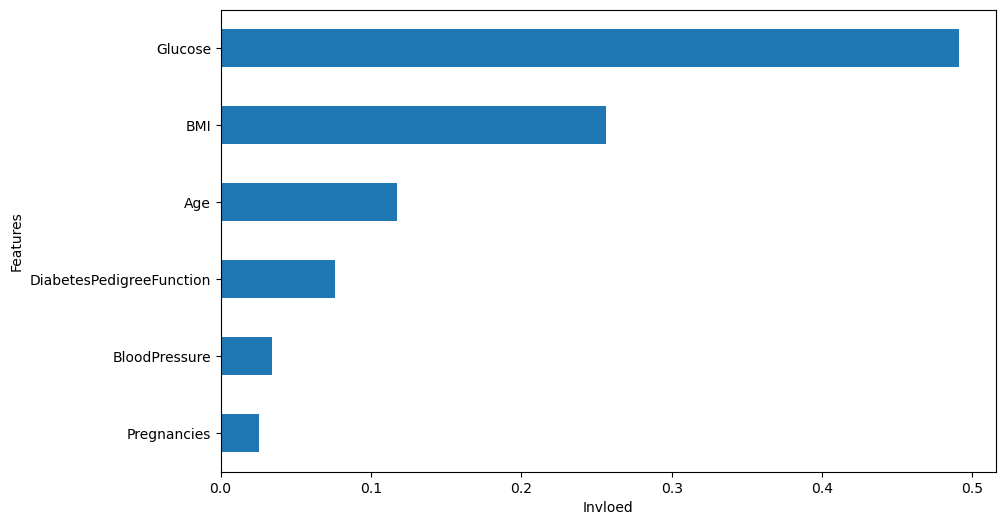

In [371]:
# Aanmaken en sorteren invloed kolommen
invloed = pd.Series(gb_tuned.feature_importances_, index=X.columns)
invloed = invloed.sort_values(ascending=True)

# Plotten grafiek met invloed
invloed.plot(kind='barh', figsize=(10, 6))
plt.ylabel('Features')
plt.xlabel('Invloed')
plt.show()

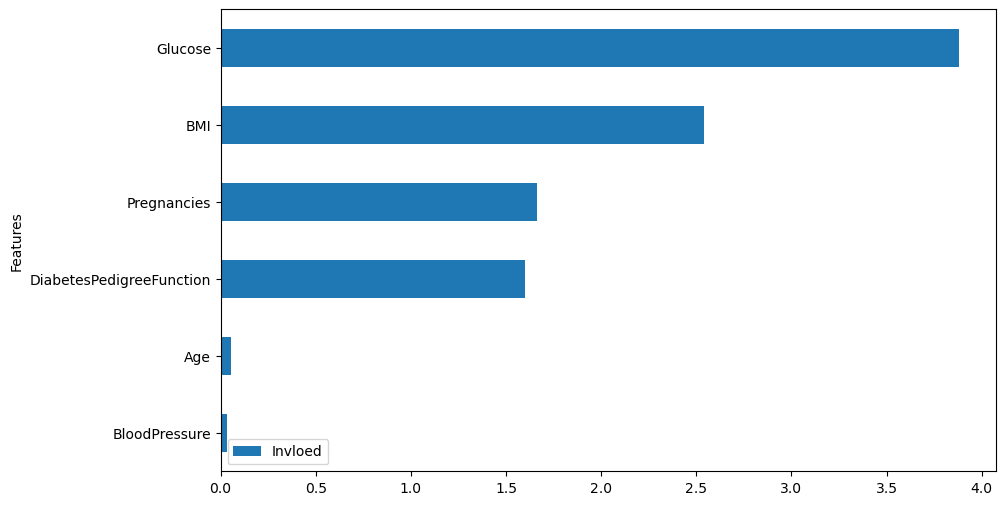

In [372]:
# Bepalen van coëfficienten
coef = svmc_tuned.coef_[0]

# Aanmaken en plotten invloed DF
invloed = pd.DataFrame({'Features': X.columns, 'Invloed': np.abs(coef)})
invloed = invloed.sort_values('Invloed', ascending=True)
invloed.plot(x='Features', y='Invloed', kind='barh', figsize=(10, 6))
plt.show()

Om te bepalen welke features het meeste invloed heeft op onze voorspellingen hebben wij feature_importances_ voor Gradient Boosting modellen en de absolute waardes svm gebruikt. Hieruit blijkt dat de features die het meeste invloed hebben op onze voorspellingen glucose en bmi zijn. 

Bij de EDA hebben we gekeken naar de correlaties tussen de features. Hier viel ons op de glucose een grote correlatie heeft met de outcome. Bij het bekijken van de feature importances kwam ook tevoren dat glucose een veel hogere invloed heeft op de voorspelling dan de meeste andere features. Ook consistent is dat BMI op de 2de plek te vinden is. Samen hebben deze waarden de meeste invloed gehad op de voorspellingen die zijn gemaakt in dit notebook.

### **H5.2: Advies aan de arts**
Voor een arts is het belangrijk om naar de glucose en bmi waardes te kijken van een patiënt. Als deze waarde erg hoog zijn, loopt de patiënt een groter risico op het hebben/ontwikkelen van diabetes. Voor de arts kan deze informatie een goede indicator geven voor mogelijke extra onderzoeken in diabetes gerelateerde klachten, om zo meer patiënten vroegtijdig te kunnen helpen. 

Tijdens het maken van deze keuze kwamen we voornamelijk terug op twee modellen, Logistic Regression en Support Vector Machines. Tussen deze twee modellen is er gekozen voor het Logistic Regression model. Het voordeel van Logistic Regression is dat het eenvoudig te begrijpen en te implementeren is. Dit zorgt ervoor dat de arts gemakkelijker met het model aan de slag kan en een beter begrip heeft van de voorspellingen. Ook heeft Logistic Regression minder kracht nodig om uitgevoerd te worden t.o.v. Support Vector Machines. En hoewel het Logistic Regression model niet het beste scoort in het notebook, heeft het de op één na hoogste f1-score op Kaggle. De andere modellen in het notebook zijn kwetsbaarder voor overfitting, hebben lagere scores of zijn lastiger te begrijpen. Daarom zijn deze modellen al meteen buiten wegen gelaten.

Kortom: Logistic Regression heeft de voorkeur gekregen doordat het een eenvoudiger begrip geeft, het is gemakkelijker te implementeren en het heeft minder kracht nodig dan de andere modellen.

## ***Literatuurlijst***

### **Logistic Regression**
Nagpal, A. (2022, 05 januari). L1 and L2 Regularization Methods, Explained. Builtin. <br> https://builtin.com/data-science/l2-regularization.

Gradient Descent in Machine Learning. (z.d.). Javapoint. <br> https://www.javatpoint.com/gradient-descent-in-machine-learning

Jain, A. (2023). Ridge and lasso regression in Python | Complete tutorial (Updated 2023). Analytics Vidhya. <br> https://www.analyticsvidhya.com/blog/2016/01/ridge-lasso-regression-python-complete-tutorial/

Team, D. S. (2020). Regularisatie. DATA SCIENCE. <br> https://datascience.eu/nl/machine-learning/regularisatie-in-machinaal-leren/

Week 2 - 2023 Machine Learning VT Powerpoint Slides. (n.d.). <br> https://brightspace.hhs.nl/d2l/le/lessons/56591/lessons/578907

### **Decision Tree**
Hoare, J. (2022, September 13). Pruning decision trees and machine Learning - Displayr. Displayr. <br> https://www.displayr.com/machine-learning-pruning-decision-trees/

ChatGPT, 2023, prompt 1: Increase Tree Plot size. <br> https://chat.openai.com/share/878ee097-cee4-4ee3-92f9-9d428b617eb9

Singh, D. (2022, March 12). Criterion used in Constructing Decision Tree - Geek Culture - Medium. Medium. <br> https://medium.com/geekculture/criterion-used-in-constructing-decision-tree-c89b7339600f

1.10. Decision Trees. (n.d.). Scikit-learn. <br> https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning

### **Random Forest**
Datacamp. (n.d.). Bagging and random forests - bagging. Full Course. DataCamp. <br> https://campus.datacamp.com/courses/machine-learning-with-tree-based-models-in-python/bagging-and-random-forests?ex=1

What is Random Forest? | IBM. (n.d.). <br> https://www.ibm.com/topics/random-forest

sklearn.ensemble.RandomForestClassifier. (n.d.). Scikit-learn. <br> https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Lawrence, B. (2018, July 20). Decision trees — pruning - towards data science. Medium. <br> https://towardsdatascience.com/decision-trees-pruning-4241cc266fef

Wikipedia contributors. (2023). Decision tree pruning. Wikipedia. <br> https://en.wikipedia.org/wiki/Decision_tree_pruning

### **ADA Boosting**
Datacamp. (n.d.). Boosting - Adaboost. [Video]. DataCamp. <br> https://campus.datacamp.com/courses/machine-learning-with-tree-based-models-in-python/boosting?ex=1

### **Gradient Boosting**
Week 4 - 2023 Machine Learning VT Powerpoint Slides. (n.d.). <br> https://brightspace.hhs.nl/d2l/le/lessons/56591/lessons/579395

1.11. Ensembles: Gradient boosting, random forests, bagging, voting, stacking. (n.d.). Scikit-learn. <br> https://scikit-learn.org/stable/modules/ensemble.html#histogram-based-gradient-boosting

### **Support Vector Machines**
Tieleman, P. (2023). Support Vector Machine in Python: uitleg & tutorial. Data Science Partners | Trainingen Data Science in Python, SQL & R. https://datasciencepartners.nl/support-vector-machine/

Pupale, R. (2022, March 9). Support Vector Machines(SVM) — An Overview - Towards Data Science. Medium. <br> https://towardsdatascience.com/https-medium-com-pupalerushikesh-svm-f4b42800e989

Jain, A. (2023). Ridge and lasso regression in Python | Complete tutorial (Updated 2023). Analytics Vidhya. <br> https://www.analyticsvidhya.com/blog/2016/01/ridge-lasso-regression-python-complete-tutorial/

Roun (2013) What is the loss function of hard margin SVM? Cross Validated. <br> https://stats.stackexchange.com/questions/74499/what-is-the-loss-function-of-hard-margin-svm

Team, D. S. (2020). Hoofdstuk 2 : SVM (Support Vector Machine) – Theorie. DATA SCIENCE. <br> https://datascience.eu/nl/wiskunde-statistiek/hoofdstuk-2-svm-support-vector-machine-theorie/

Team, D. S. (2020). Regularisatie. DATA SCIENCE. <br> https://datascience.eu/nl/machine-learning/regularisatie-in-machinaal-leren/

Sklearn.svm.SVC. (n.d.). Scikit-learn. <br> https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

### **Naive Bayes**
Wikipedia contributors. (2023). Bayes’ theorem. Wikipedia. <br> https://en.wikipedia.org/wiki/Bayes%27_theorem

sklearn.naive_bayes.GaussianNB. (n.d.). Scikit-learn. <br> https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB

1.9. Naive Bayes. (n.d.). Scikit-learn. <br> https://scikit-learn.org/stable/modules/naive_bayes.html

### **Ensemble**
Awan-Ur-Rahman. (2023, August 3). Understanding soft voting and hard voting: A Comparative analysis of ensemble learning methods. Medium. https://medium.com/@awanurrahman.cse/understanding-soft-voting-and-hard-voting-a-comparative-analysis-of-ensemble-learning-methods-db0663d2c008

sklearn.ensemble.VotingClassifier. (n.d.). Scikit-learn. <br> https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
